### 0. Setting up the analysis directories & common variables and Loading necessary packages


In [1]:
# set work directory 
%pwd
%cd /scicore/home/schiera/liu0005/scMultiome_embryo/scenicplus_analysis
%pwd

/scicore/home/schiera/liu0005/scMultiome_embryo/scenicplus_analysis


'/scicore/home/schiera/liu0005/scMultiome_embryo/scenicplus_analysis'

In [2]:
# supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [3]:
# project directory
projDir = '/scicore/home/schiera/liu0005/scMultiome_embryo/scenicplus_analysis/'

In [4]:
# output directory
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [5]:
# temporary directory
tmpDir = '/scicore/home/schiera/liu0005/tmp/'
import os
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)

In [6]:
# necessary packages
import pickle
import os
import dill
import pandas as pd
import numpy as np
import pyranges as pr
import scanpy as sc
import time


from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import *
from pycisTopic.topic_binarization import *
from pycisTopic.topic_qc import *
from pycisTopic.diff_features import *
from pycistarget.utils import region_names_to_coordinates
from scenicplus.wrappers.run_pycistarget import run_pycistarget
from scenicplus.scenicplus_class import create_SCENICPLUS_object
from scenicplus.cistromes import *
from scenicplus.enhancer_to_gene import get_search_space, calculate_regions_to_genes_relationships, GBM_KWARGS
from scenicplus.TF_to_gene import *
from scenicplus.grn_builder.gsea_approach import build_grn
from scenicplus.utils import format_egrns
from scenicplus.eregulon_enrichment import *
from scenicplus.plotting.correlation_plot import *
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.RSS import *
from scenicplus.plotting.dotplot import *
from scenicplus.loom import *




### 1. Creating a cisTopic object
tutorial comes from https://pycistopic.readthedocs.io/en/latest/Single_sample_workflow-RTD.html#

In [6]:
# read count matrix of peaks 
count_matrix = pd.read_feather(projDir + 'data/atac_data/highToSomite.peaks.counts.feather')
# read peak names and cell names, and use them as row names and colume names for count matrix
peak_names = pd.read_csv(projDir + 'data/atac_data/peak.txt', header=None, sep='\t')
count_matrix.index = peak_names[0]
cell_names = pd.read_csv(projDir + 'data/atac_data/cell.txt', header=None, sep='\t')
count_matrix.columns = cell_names[0]


In [ ]:
# check the matrix
count_matrix

In [8]:
# create cisTopic object
cistopic_obj = create_cistopic_object(fragment_matrix=count_matrix)
# adding cell information
cell_data =  pd.read_csv(projDir+'data/atac_data/cell.metadata.txt', sep='\t')
cistopic_obj.add_cell_data(cell_data)

2022-10-30 14:17:36,470 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-10-30 14:22:17,102 cisTopic     INFO     Creating CistopicObject
2022-10-30 14:22:28,669 cisTopic     INFO     Done!


In [9]:
# check attributes of cistopic_obj
cistopic_obj_attri = (vars(cistopic_obj))
print(cistopic_obj_attri.keys())
print(cistopic_obj_attri['cell_data'])

dict_keys(['fragment_matrix', 'binary_matrix', 'cell_names', 'region_names', 'cell_data', 'region_data', 'project', 'path_to_fragments', 'selected_model', 'projections'])


In [11]:
# save cistopic_obj
with open(outDir + 'zf_highToSomite_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

### 2. Run models


In [12]:
# load cisTopic object
infile = open(outDir + 'zf_highToSomite_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [13]:
cistopic_obj

In [ ]:
# run models
# 90g memory can only run one model
models=run_cgs_models(cistopic_obj,
                    n_topics=[400], ## for 10 topics, it only takes 2h, but for 200 topics, it takes 30h
                    n_cpu=40, # The parallelization is done between models rather than within each model
                              # so, if only with one model, then use only one cpu.
                    n_iter=100,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    _temp_dir=tmpDir)
# save
with open(outDir + 'models/zf_highToSomite_models_400.pkl', 'wb') as f:
  pickle.dump(models, f)


2022-10-22 14:38:52,950	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(run_cgs_model pid=236156) 2022-10-22 14:39:04,765 cisTopic     INFO     Running model with 200 topics
(run_cgs_model pid=236139) 2022-10-22 14:39:04,767 cisTopic     INFO     Running model with 90 topics
(run_cgs_model pid=236160) 2022-10-22 14:39:04,764 cisTopic     INFO     Running model with 100 topics


In [ ]:
'''
# this Mallet method is not working for some reasons 
from pycisTopic.lda_models import *
# configure path Mallet
path_to_mallet_binary = '/scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/bin/mallet'
# run models
models=run_cgs_models_mallet(path_to_mallet_binary,
                    cistopic_obj,
                    n_topics=[60],
                    n_cpu=40, # The parallelization is done within each model. 
                    n_iter=100,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    tmp_path='/scicore/home/schiera/liu0005/tmp/',
                    save_path='/scicore/home/schiera/liu0005/tmp/')
# save
with open(outDir + 'models/zf_highToSomite_mallet_models_60.pkl', 'wb') as f:
  pickle.dump(models, f)


### 3. Model selection


In [28]:
infile1 = open(outDir + 'models/zf_highToSomite_models_10.pkl', 'rb')
infile2 = open(outDir + 'models/zf_highToSomite_models_20.pkl', 'rb')
infile3 = open(outDir + 'models/zf_highToSomite_models_30_40.pkl', 'rb')
infile4 = open(outDir + 'models/zf_highToSomite_models_50.pkl', 'rb')
infile5 = open(outDir + 'models/zf_highToSomite_models_60_70_80.pkl', 'rb')
infile6 = open(outDir + 'models/zf_highToSomite_models_90_100_200.pkl', 'rb')
infile7 = open(outDir + 'models/zf_highToSomite_models_150.pkl', 'rb')
infile8 = open(outDir + 'models/zf_highToSomite_models_250.pkl', 'rb')
infile9 = open(outDir + 'models/zf_highToSomite_models_300.pkl', 'rb')
infile10 = open(outDir + 'models/zf_highToSomite_models_400.pkl', 'rb')

models1 = pickle.load(infile1)
models2 = pickle.load(infile2)
models3 = pickle.load(infile3)
models4 = pickle.load(infile4)
models5 = pickle.load(infile5)
models6 = pickle.load(infile6)
models7 = pickle.load(infile7)
models8 = pickle.load(infile8)
models9 = pickle.load(infile9)
models10 = pickle.load(infile10)

infile1.close()
infile2.close()
infile3.close()
infile4.close()
infile5.close()
infile6.close()
infile7.close()
infile8.close()
infile9.close()
infile10.close()

models = models1 + models2 + models3 + models4 + models5 + models6 + models7 + models8 + models9 + models10

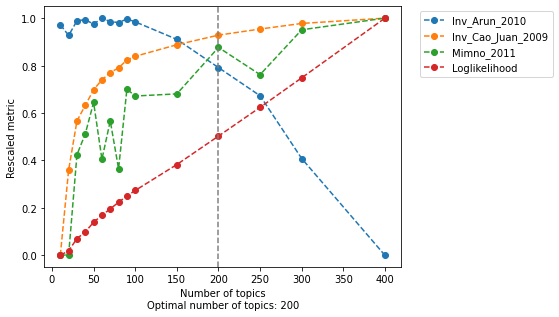

In [29]:
model=evaluate_models(models,
                     return_model=True,
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'models/model_selection.pdf')

In [ ]:
model.

In [14]:

# add model to cisTopicObject
cistopic_obj.add_LDA_model(model)


In [15]:
# save
with open(outDir + 'zf_highToSomite_cisTopicObject_withTopics.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

### 4. Inferring candidate enhancer regions


#### 4.1 Topic binarization & qc

In [25]:
# load cisTopic object
infile = open(outDir + 'zf_highToSomite_cisTopicObject_withTopics.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [ ]:
# binarize the topic-region distribution
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)
# if we calculate region_bin_topics_otsu after region_bin_topics_top3k, the topic_qc_metrics will show the region per topic based on region_bin_topics_otsu, otherwise it will show region_bin_topics_top3k
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu',plot=True, num_columns=5, save= outDir + 'topic_binarization/otsu.pdf')

In [ ]:
# we can now binarize the cell-topic distribions.
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=100)
## if We see that some thresholds are not very accurate. We can adjust the manually.
#predefined_thr={'Topic12':0.7, 'Topic13':0.4, 'Topic27':0.5}
#binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=100, predefined_thr=predefined_thr)

In [38]:
# we can compute the topic quality control metrics (it takes 10 min)
topic_qc_metrics = compute_topic_metrics(cistopic_obj)
topic_qc_metrics

In [ ]:
# create a figure dictionary to put all plots together
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

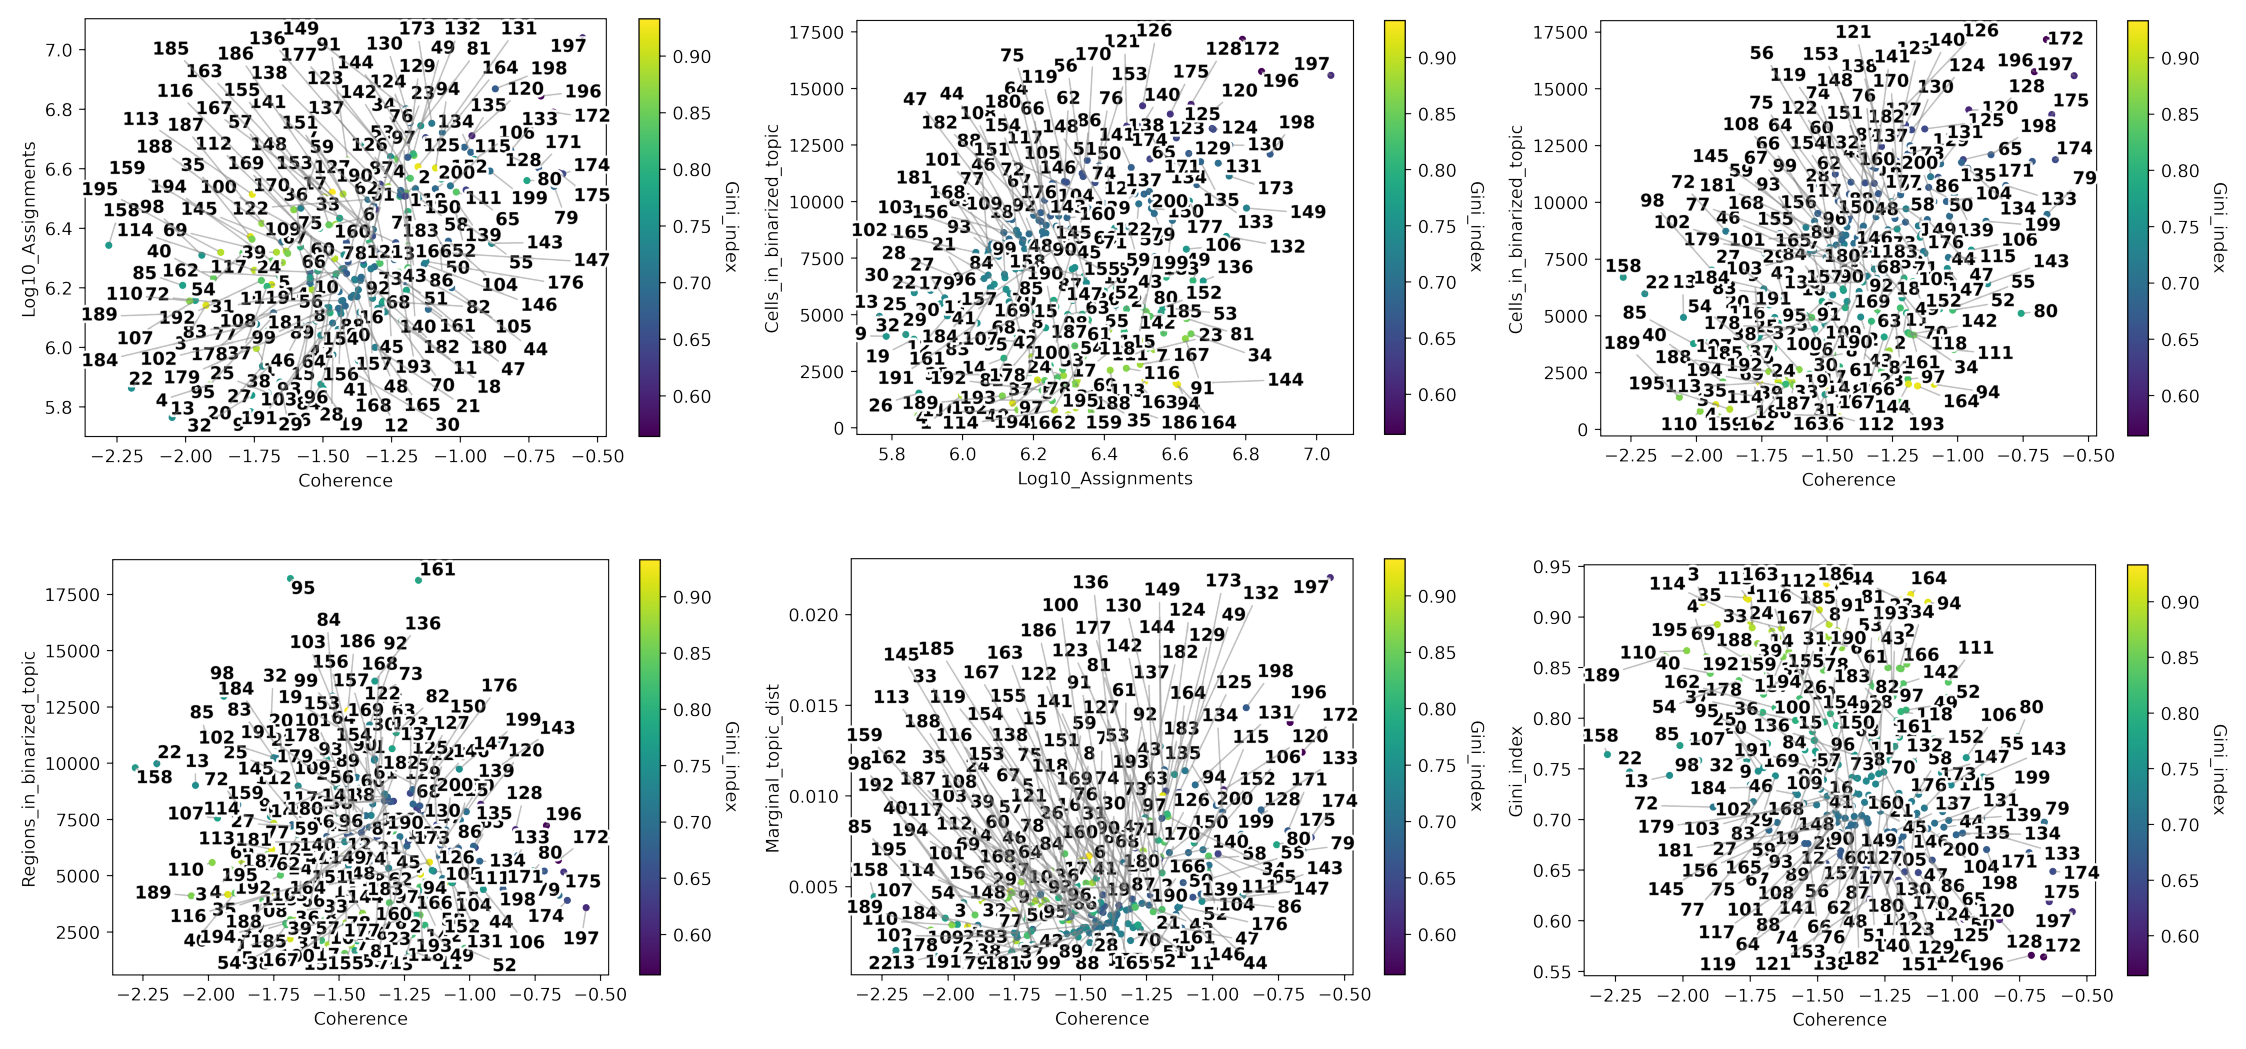

In [44]:
# plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(outDir + 'topic_binarization/Topic_qc.pdf', bbox_inches='tight')
plt.show()

In [ ]:
topic_annot = topic_annotation(cistopic_obj, annot_var='celltype', binarized_cell_topic=binarized_cell_topic, general_topic_thr = 0.2)
topic_annot

In [ ]:
# We can merge the topic metrics and their annotation in a data frame.
topic_qc_metrics = pd.concat([topic_annot[['celltype', 'Ratio_cells_in_topic', 'Ratio_group_in_population']], topic_qc_metrics], axis=1)


In [94]:
topic_qc_metrics.head(1)

celltype  \
Topic1  hatching gland(6somite), hatching gland(bud), lens placode(6somite), endoderm(75epi), endothelial progenitors(6somite), cephalic mesoderm(6somite), cephalic mesoderm(bud), prechordal plate(75epi), lateral plate mesoderm(75epi), lateral plate mesoderm(bud), endoderm(6somite), notochord(75epi), ventral diencephalon(6somite), ventral diencephalon(bud), neural floorplate(6somite), endoderm(bud), notochord(bud)   

       Ratio_cells_in_topic Ratio_group_in_population  Log10_Assignments  \
Topic1             0.035104                  0.088066           5.996757   

        Assignments  Cells_in_binarized_topic  Regions_in_binarized_topic  \
Topic1       992561                      1439                        2239   

        Coherence  Marginal_topic_dist  Gini_index  
Topic1  -1.742742             0.002014    0.889426

In [27]:
# save
with open(outDir + 'topic_binarization/Topic_qc_metrics_annot.pkl', 'wb') as f:
  pickle.dump(topic_qc_metrics, f)
with open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'wb') as f:
  pickle.dump(binarized_cell_topic, f)
with open(outDir + 'topic_binarization/binarized_topic_region_otsu.pkl', 'wb') as f:
  pickle.dump(region_bin_topics_otsu, f)
with open(outDir + 'topic_binarization/binarized_topic_region_top3k.pkl', 'wb') as f:
  pickle.dump(region_bin_topics_top3k, f)


#### 4.2 Differentially Accessible Regions (DARs) Accessible Regions (DARs)

In [2]:
# load cisTopic object
infile = open(outDir + 'zf_highToSomite_cisTopicObject_withTopics.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()


In [2]:
# impute the region accessibility exploting the cell-topic and topic-region probabilities
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)


2022-10-24 19:40:18,644 cisTopic     INFO     Imputing drop-outs
2022-10-24 19:41:01,055 cisTopic     INFO     Scaling
2022-10-24 19:41:39,657 cisTopic     INFO     Keep non zero rows
2022-10-24 19:42:30,574 cisTopic     INFO     Imputed accessibility sparsity: 0.48989547717527104
2022-10-24 19:42:30,578 cisTopic     INFO     Create CistopicImputedFeatures object
2022-10-24 19:42:30,579 cisTopic     INFO     Done!


In [7]:
# save
with open(outDir + 'DARs/imputed_acc_obj.pkl', 'wb') as f:
  pickle.dump(imputed_acc_obj, f)

##### we don't do log-normalize the imputed data, identify highly variable regions,identify differentially accessible regions. We do this part in archr, since archr is much faster and needs much less memory. Here, even 270g memory is not enough   

In [4]:
'''
# log-normalize the imputed data
# even for 270g memory we can only process for 25000 cells, so we need split the 40992 cells into two parts
c1 = imputed_acc_obj.mtx[:,0:20000] ## get the first 20'000 cells
from pycisTopic.diff_features import *
scale_factor=10**6 # since we have half million peaks, so scale factor should be in the same magnitude 
c1 = normalize(c1, norm="l1", axis=0) # for each column (a cell), each elelment divided by the sum of all elelemnts in this coulmn  
c1 *= scale_factor
c1 = np.log1p(c1) ## except 0, the minimal value is 0.8285494910665001, the second minimal is 1.2753598240517567 
c1 = np.around(c1,decimals=2) 
## we need save c1 and remove c1, otherwise there is no memory for c2
with open(outDir + 'DARs/normalized_imputed_acc_1-20000cells_ndarray.pkl', 'wb') as f:
  pickle.dump(c1, f)
del c1

c2 = imputed_acc_obj.mtx[:,20000:40992] ## get the last 20'992 cells
from pycisTopic.diff_features import *
scale_factor=10**6
c2 = normalize(c2, norm="l1", axis=0) # for each column (a cell), each elelment divided by the sum of all elelemnts in this coulmn  
c2 *= scale_factor
c2 = np.log1p(c2)
c2 = np.around(c2,decimals=2) 
with open(outDir + 'DARs/normalized_imputed_acc_20001-40992cells_ndarray.pkl', 'wb') as f:
  pickle.dump(c2, f)
del c2


In [6]:
'''
## change imputed_acc_obj values as normalized ones 
# change data type to float32, since the normalized value is in float32, we need use the normalized value replace the current ones 
imputed_acc_obj.mtx = imputed_acc_obj.mtx.astype(np.float32)

infile1 = open(outDir + 'DARs/normalized_imputed_acc_1-20000cells_ndarray.pkl', 'rb')
c1 = pickle.load(infile1)
infile1.close()
imputed_acc_obj.mtx[:,0:20000] = c1[:,0:20000]
del c1

infile2 = open(outDir + 'DARs/normalized_imputed_acc_20001-40992cells_ndarray.pkl', 'rb')
c2 = pickle.load(infile2)
infile2.close()
imputed_acc_obj.mtx[:,20000:40992] = c2[:,0:20992]
del c2


In [15]:
'''
# save normalized one 
with open(outDir + 'DARs/normalized_imputed_acc_obj.pkl', 'wb') as f:
  pickle.dump(imputed_acc_obj, f)

In [17]:
'''
del imputed_acc_obj

In [1]:
'''
infile = open(outDir + 'DARs/normalized_imputed_acc_obj.pkl', 'rb')
normalized_imputed_acc_obj = pickle.load(infile)
infile.close()

2022-10-25 12:41:33,475 cisTopic     INFO     Calculating mean
2022-10-25 12:41:40,040 cisTopic     INFO     Calculating variance


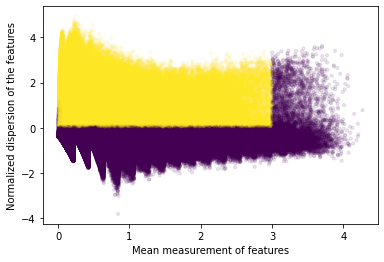

2022-10-25 12:43:00,037 cisTopic     INFO     Done!


In [2]:
'''
# identify highly variable regions
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125,
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20,
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot.pdf')

In [7]:
'''
# save variable_regions
with open(outDir + 'DARs/variable_regions.pkl', 'wb') as f:
  pickle.dump(variable_regions, f)

    

In [ ]:
'''
## identify differentially accessible regions 
# load imputed_acc object
infile1 = open(outDir + 'DARs/imputed_acc_obj.pkl', 'rb')
imputed_acc_obj = pickle.load(infile1)
infile1.close()
# load varaible regions
import pickle
infile2 = open(outDir + 'DARs/variable_regions.pkl', 'rb')
variable_regions = pickle.load(infile2)
infile2.close()

# we do this part in archr, since there is enough memory even we ask 270g  
markers_dict= find_diff_features(cistopic_obj,
                      imputed_acc_obj,
                      variable='celltype',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=1) # there is a memory issue if we set pvalue > 1, each cell type costs 7 min
                               # even set cup=1, there is still no enough memory after finished runing 8 cell types

##### we use the DARs from archr, whcih is much faster and less memory 


In [48]:
DAR = pd.read_csv(outDir + '/DARs/DAR.txt', sep='\t') # for DAR.txt file, it has four columns, but the first row only has three columns (Log2FC, Adjusted_pval, Contrast)
                                                   # In this way, the first column will be row names after read the file into jupyter notebook    

cell_types=np.unique(DAR["Contrast"])              # we don't use cell types with less than 100 differential peaks, since after promoter filtering, it may not contains any peaks anymore, then run_pycistarget won't work anymore
## make DAR as a dictionary 
markers_dict = {}
for i in range(len(cell_types)):
        markers_dict[np.unique(DAR["Contrast"])[i]] = DAR[DAR["Contrast"]==cell_types[i]]

In [49]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]


adaxial cells(6somite): 1059
adaxial cells(75epi): 784
adaxial cells(bud): 2782
anterior neural plate border(bud): 3009
cephalic mesoderm(6somite): 659
cephalic mesoderm(bud): 3683
deep cells(oblong): 2731
dorsal anterior(50epi): 710
dorsal anterior(shield): 1172
dorsal diencephalon(6somite): 1036
dorsal diencephalon(bud): 3642
dorsal ectoderm(50epi): 451
dorsal ectoderm(shield): 853
dorsal posterior(50epi): 777
dorsal posterior(shield): 1534
ectoderm(30epi): 2033
ectoderm(dome): 2274
endoderm(6somite): 201
endoderm(75epi): 1612
endoderm(bud): 2009
endoderm(shield): 1434
epidermis(6somite): 11116
epidermis(75epi): 3028
epidermis(bud): 9070
evl(30epi): 3715
evl(50epi): 21119
evl(6somite): 5082
evl(75epi): 25519
evl(bud): 15179
evl(dome): 1131
evl(shield): 33715
hatching gland(6somite): 918
hatching gland(bud): 2151
heart field(6somite): 2164
high cells: 204
hindbrain(6somite): 3369
hindbrain(bud): 3758
lateral plate mesoderm(75epi): 3551
lateral plate mesoderm(bud): 4571
lens placode(6s

In [80]:
# save
with open(outDir + 'DARs/DARs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)


### 5. Motif enrichment analysis using pycistarget
tutorial comes from: https://scenicplus.readthedocs.io/en/latest/pbmc_multiome_tutorial.html#Motif-enrichment-analysis-using-pycistarget

In [7]:
region_bin_topics_otsu = pickle.load(open(os.path.join(outDir, 'topic_binarization/binarized_topic_region_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(outDir, 'topic_binarization/binarized_topic_region_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(outDir, 'DARs/DARs.pkl'), 'rb'))

In [8]:
# convert to dictionary of pyranges objects.
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [14]:
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')


topics_otsu: 
topics_top_3: 
DARs: 


In [19]:
region_sets['topics_otsu']['Topic1']

+--------------+-----------+-----------+
| Chromosome   | Start     | End       |
| (category)   | (int32)   | (int32)   |
|--------------+-----------+-----------|
| chr1         | 39455761  | 39456261  |
| chr1         | 45758707  | 45759207  |
| chr1         | 46493435  | 46493935  |
| chr1         | 168701    | 169201    |
| ...          | ...       | ...       |
| chr25        | 3870519   | 3871019   |
| chr25        | 31564724  | 31565224  |
| chr25        | 2815675   | 2816175   |
| chr25        | 18216903  | 18217403  |
+--------------+-----------+-----------+
Unstranded PyRanges object has 2,239 rows and 3 columns from 25 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

In [ ]:
# change the data format for rankings database and scores database
rankings_db = os.path.join(projDir, 'data/motif_data/motif.ranks.v2.feather')
scores_db =  os.path.join(projDir, 'data/motif_data/motif.scores.v2.feather')

rankings_data = pd.read_feather(rankings_db)
rankings_data2 = rankings_data.iloc[:,0:444653].astype('int32') # change ranking as int32
rankings_data2.iloc[:,444653:444654] = rankings_data.iloc[:,444653:444654]
rankings_data3 = pd.concat([rankings_data2, rankings_data.iloc[:,444653:444654]], axis=1)
# the name of the feather file need have a strict name format: 
# the last part should be: .regions_vs_motifs.rankings.feather or .regions_vs_motifs.scores.feather  
rankings_data3.to_feather ("/scicore/home/schiera/liu0005/scMultiome_embryo/scenicplus_analysis/data/motif_data/cluster_SCREEN.regions_vs_motifs.rankings.feather")

scores_data = pd.read_feather(scores_db)
scores_data2 = scores_data.iloc[:,0:444653].astype('float32')  # change score as float32
scores_data2.iloc[:,444653:444654] = scores_data.iloc[:,444653:444654]
scores_data3 = pd.concat([scores_data2, scores_data.iloc[:,444653:444654]], axis=1)
# the name of the feather file need have a strict name format: 
# the last part should be: .regions_vs_motifs.rankings.feather or .regions_vs_motifs.scores.feather  
scores_data3.to_feather ("/scicore/home/schiera/liu0005/scMultiome_embryo/scenicplus_analysis/data/motif_data/cluster_SCREEN.regions_vs_motifs.scores.v2.feather")


In [20]:
rankings_data

chr10:10002944-10003444  chr10:10003889-10004389  \
0                   210970.0                 140162.0   
1                   210970.0                 140162.0   
2                   210970.0                 140162.0   
3                   210970.0                 140162.0   
4                   210970.0                 140162.0   
..                       ...                      ...   
907                 116087.0                 275516.0   
908                  72519.0                 153827.0   
909                 340369.0                 113664.0   
910                 382654.0                  65343.0   
911                 382654.0                  65343.0   

     chr10:10004783-10005283  chr10:10008043-10008543  \
0                   329619.0                 139625.0   
1                   329619.0                 139625.0   
2                   329619.0                 139625.0   
3                   329619.0                 139625.0   
4                   329619.0                 139625.0   
..                       ...                      ...   
907                 421974.0                 166876.0   
908                 112587.0                 152487.0   
909                 280685.0                 409479.0   
910                   9933.0                 137071.0   
911                   9933.0                 137071.0   

     chr10:10010515-10011015  chr10:10013193-10013693  \
0                    12098.0                 141625.0   
1                    12098.0                 141625.0   
2                    12098.0                 141625.0   
3                    12098.0                 141625.0   
4                    12098.0                 141625.0   
..                       ...                      ...   
907                  55116.0                 234540.0   
908                 164072.0                  72289.0   
909                 258887.0                 195843.0   
910                 377358.0                 382655.0   
911                 377358.0                 382655.0   

     chr10:10015603-10016103  chr10:10016141-10016641  \
0                   252753.0                 440251.0   
1                   252753.0                 440251.0   
2                   252753.0                 440251.0   
3                   252753.0                 440251.0   
4                   252753.0                 440251.0   
..                       ...                      ...   
907                 233367.0                 156814.0   
908                 427372.0                 388657.0   
909                 364326.0                  44322.0   
910                 160793.0                 409440.0   
911                 160793.0                 409440.0   

     chr10:10017245-10017745  chr10:10017906-10018406  ...  \
0                    95493.0                 309483.0  ...   
1                    95493.0                 309483.0  ...   
2                    95493.0                 309483.0  ...   
3                    95493.0                 309483.0  ...   
4                    95493.0                 309483.0  ...   
..                       ...                      ...  ...   
907                 355398.0                 384833.0  ...   
908                  84688.0                 397434.0  ...   
909                 337690.0                 187127.0  ...   
910                 124034.0                 148695.0  ...   
911                 124034.0                 148695.0  ...   

     chr9:9980361-9980861  chr9:9982342-9982842  chr9:99830-100330  \
0                 43980.0              186246.0           339773.0   
1                 43980.0              186246.0           339773.0   
2                 43980.0              186246.0           339773.0   
3                 43980.0              186246.0           339773.0   
4                 43980.0              186246.0           339773.0   
..                    ...                   ...                ...   
907              185121.0     

In [9]:
# define rankings, score and motif annotation database    
rankings_db = os.path.join(projDir, 'data/motif_data/cluster_SCREEN.regions_vs_motifs.rankings.v2.feather')
scores_db =  os.path.join(projDir, 'data/motif_data/cluster_SCREEN.regions_vs_motifs.scores.v2.feather')
motif_annotation = os.path.join(projDir, 'data/motif_data/motif.annotation.txt')


In [ ]:
# run pycistarget 
# it takes 95 min when use 1 cpu
species = 'danio_rerio' # we changed the code of run_pycistarget (123th row), then reload the envioromwnt, then, we can use danio_rerio.
                        # run_pycistarget is from ~/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scenicplus/wrappers/run_pycistarget.py
run_pycistarget(
    region_sets = region_sets,
    species = species, # download the Transcription Starting Site annotations from biomart based on species name
    biomart_host = 'http://apr2020.archive.ensembl.org/', ##  use which version of ensembl annnotation. we used ensembl 100 for archr and seurat
    save_path = os.path.join(outDir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    promoter_space = 1000,
    run_without_promoters = True,
    path_to_motif_annotations = motif_annotation, # with the annatation file,  you can get the TF names of the motifs from rankings_db and scores_db
    n_cpu = 1, # wired, if we use more than 1 cpu, it's not working 
               # if sometimes set multiple cups not work, we need empty tmpDir and restart the notebook 
    _temp_dir = tmpDir, 
    annotation_version = 'danio_code_v1' # if you don't provide path_to_motif_annotations, it will based on species name and annotation version to find the motif annotations saved in scenicplus
    ) 
    

In [ ]:
# run pycistarget, ctx_nes_threshold set as 0  
# it takes 95 min when use 1 cpu
species = 'danio_rerio' # we changed the code of run_pycistarget (123th row), then reload the envioromwnt, then, we can use danio_rerio.
                        # run_pycistarget is from ~/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scenicplus/wrappers/run_pycistarget.py
run_pycistarget(
    region_sets = region_sets,
    species = species, # download the Transcription Starting Site annotations from biomart based on species name
    biomart_host = 'http://apr2020.archive.ensembl.org/', ##  use which version of ensembl annnotation. we used ensembl 100 for archr and seurat
    save_path = os.path.join(outDir, 'motifs/motifs_without_auc_filter'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    ctx_nes_threshold = 0, 
    promoter_space = 1000,
    run_without_promoters = True,
    path_to_motif_annotations = motif_annotation, # with the annatation file,  you can get the TF names of the motifs from rankings_db and scores_db
    n_cpu = 1, # wired, if we use more than 1 cpu, it's not working 
               # if sometimes set multiple cups not work, we need empty tmpDir and restart the notebook 
    _temp_dir = tmpDir, 
    annotation_version = 'danio_code_v1' # if you don't provide path_to_motif_annotations, it will based on species name and annotation version to find the motif annotations saved in scenicplus
    ) 

In [ ]:
# explore some of the results
menr = dill.load(open(os.path.join(outDir, 'motifs/menr.pkl'), 'rb'))

In [65]:
for key, value in menr.items() :
    print (key)

CTX_topics_otsu_All
CTX_topics_otsu_No_promoters
DEM_topics_otsu_All
DEM_topics_otsu_No_promoters
CTX_topics_top_3_All
CTX_topics_top_3_No_promoters
DEM_topics_top_3_All
DEM_topics_top_3_No_promoters
CTX_DARs_All
CTX_DARs_No_promoters
DEM_DARs_All
DEM_DARs_No_promoters


In [ ]:
for k1,v1 in menr['CTX_DARs_No_promoters'].items():
    
    print (k1)
    for k2, v2 in menr['CTX_DARs_No_promoters'][k1].cistromes['Database'].items():
        print (k2)

In [ ]:
## output all tfbs for each cell type specific peaks
df = pd.DataFrame(columns = ['celltype','regulon','enhancer'])
for k1,v1 in menr['CTX_DARs_All'].items():
    for k2, v2 in menr['CTX_DARs_All'][k1].cistromes['Database'].items():
        for v3 in v2: 
            #print (k1)
            #print (k2)
            #print (v3)
            df2 = pd.DataFrame({'celltype': k1, 'regulon': k2, 'enhancer': v3},index=[0])
            df = df.append(df2)
df.to_csv("output/motifs/CTX_DARs_All_regulons.txt",sep ='\t',index=False,header=True)


In [ ]:
## when work with DEM method but not CTX method
df = pd.DataFrame(columns = ['celltype','regulon','enhancer'])

for k1,v1 in menr['DEM_DARs_No_promoters'].cistromes['Database'].items():
    for k2, v2 in menr['DEM_DARs_No_promoters'].cistromes['Database'][k1].items():
        for v3 in v2: 
            df2 = pd.DataFrame({'celltype': k1, 'regulon': k2, 'enhancer': v3},index=[0])
            df = df.append(df2)
df.to_csv("output/motifs/DEM_DARs_No_promoters_regulons.txt",sep ='\t',index=False,header=True)


In [ ]:
## output enriched motifs for each cell type 

df = pd.DataFrame(columns = ['Logo','Region_set','Direct_annot','Orthology_annot','NES','AUC','Rank_at_max','Motif_hits'])

for k1,v1 in menr['CTX_DARs_All'].items():
    df2 = menr['CTX_DARs_All'][k1].motif_enrichment
    df = df.append(df2)

df.to_csv("output/motifs/CTX_DARs_All_regulons_motif_enrichment.txt",sep ='\t',index=False,header=True)


In [17]:
menr['CTX_DARs_All']['adaxial cells(6somite)'].motif_enrichment

Logo  \
myog        <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/myog.png" width="200" >   
tal1        <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/tal1.png" width="200" >   
figla      <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/figla.png" width="200" >   
myod1      <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/myod1.png" width="200" >   
ttf1.4    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/ttf1.4.png" width="200" >   
myf6        <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/myf6.png" width="200" >   
meis3      <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/meis3.png" width="200" >   
msc          <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/msc.png" width="200" >   
tcf21      <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/tcf21.png" width="200" >   
mespab    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/mespab.png" width="200" >   
mespba    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/mespba.png" width="200" >   
mespbb    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/mespbb.png" width="200" >   
mespaa    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/mespaa.png" width="200" >   
TCF4        <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/TCF4.png" width="200" >   
scrt1a    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/scrt1a.png" width="200" >   
scrt2      <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/scrt2.png" width="200" >   
scrt1b    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/scrt1b.png" width="200" >   
zic3        <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/zic3.png" width="200" >   
mef2d      <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/mef2d.png" width="200" >   
mef2ab    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/mef2ab.png" width="200" >   
mef2aa    <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/mef2aa.png" width="200" >   
gli2b      <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/gli2b.png" width="200" >   
gli1        <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/gli1.png" width="200" >   
neurod1  <img src="https://motifcollections.aertslab.org/danio_code_v1/logos/neurod1.png" width="200" >   

                     Region_set Direct_annot Orthology_annot       NES  \
myog     adaxial cells(6somite)         myog             NaN  8.139853   
tal1     adaxial cells(6somite)         tal1             NaN  5.777286   
figla    adaxial cells(6somite)        figla             NaN  5.761635   
myod1    adaxial cells(6somite)        myod1             NaN  5.610823   
ttf1.4   adaxial cells(6somite)       ttf1.4             NaN  5.342396   
myf6     adaxial cells(6somite)         myf6             NaN  5.342396   
meis3    adaxial cells(6somite)        meis3             NaN  4.601930   
msc      adaxial cells(6somite)          msc             NaN  4.549763   
tcf21    adaxial cells(6somite)        tcf21             NaN  4.400689   
mespab   adaxial cells(6somite)       mespab             NaN  4.113608   
mespba   adaxial cells(6somite)       mespba             NaN  4.113608   
mespbb   adaxial cells(6somite)       mespbb             NaN  4.113608   
mespaa   adaxial cells(6somite)       mespaa             NaN  4.113608   
TCF4     adaxial cells(6somite)         TCF4             NaN  3.668444   
scrt1a   adaxial cells(6somite)       scrt1a             NaN  3.597780   
scrt2    adaxial cells(6somite)        scrt2             NaN  3.597780   
scrt1b   adaxial cells(6somite)       scrt1b             NaN  3.597780   
zic3     adaxial cells(6somite)         zic3             NaN  3.592721   
mef2d    adaxial 

In [66]:
menr['DEM_DARs_All'].DEM_results('adaxial cells(6somite)')


### 6.inferring enhancer-driven Gene Regulatory Networks (eGRNs) using SCENIC+
tutorial comes from: https://scenicplus.readthedocs.io/en/latest/Scenicplus_step_by_step-RTD.html#

In [7]:
# load the data for SCENIC+
adata = sc.read_h5ad(os.path.join(projDir, 'data/rna_data/highTOsomite6.h5ad'))
cistopic_obj = dill.load(open(os.path.join(projDir, 'output/zf_highToSomite_cisTopicObject_withTopics.pkl'), 'rb'))
menr = dill.load(open(os.path.join(projDir, 'output/motifs/menr.pkl'), 'rb'))
# imputed_acc_obj = dill.load(open(os.path.join(projDir, 'output/DARs/imputed_acc_obj.pkl'), 'rb'))

In [8]:
# check cell name in atacseq data 
cistopic_obj_attri = (vars(cistopic_obj))
print(cistopic_obj_attri.keys())
cistopic_obj_attri['cell_data'].head(3)


dict_keys(['fragment_matrix', 'binary_matrix', 'cell_names', 'region_names', 'cell_data', 'region_data', 'project', 'path_to_fragments', 'selected_model', 'projections'])


cisTopic_nr_frag cisTopic_log_nr_frag  \
high_CGTGCTGCATGCTTAG-1___cisTopic            41625             4.619354   
high_GGGCAATAGTTAACCA-1___cisTopic            32104             4.506559   
high_GTACAATGTAGGATCC-1___cisTopic            32947             4.517816   

                                   cisTopic_nr_acc cisTopic_log_nr_acc  \
high_CGTGCTGCATGCTTAG-1___cisTopic           34712             4.54048   
high_GGGCAATAGTTAACCA-1___cisTopic           27277            4.435797   
high_GTACAATGTAGGATCC-1___cisTopic           28057            4.448041   

                                   sample_id  n_genes  total_counts  \
high_CGTGCTGCATGCTTAG-1___cisTopic  cisTopic      921          1446   
high_GGGCAATAGTTAACCA-1___cisTopic  cisTopic     1566          2754   
high_GTACAATGTAGGATCC-1___cisTopic  cisTopic     1247          2085   

                                    pct_conuts_mt    celltype  
high_CGTGCTGCATGCTTAG-1___cisTopic       2.297297  high cells  
high_GGGCAATAGTTAACCA-1___cisTopic      30.030488  high cells  
high_GTACAATGTAGGATCC-1___cisTopic      18.427230  high cells

In [9]:
# check the cell name in rnaseq data 
adata.obs.head(3)

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
high_CGTGCTGCATGCTTAG-1       high      1446.0           921    2.297297   
high_GGGCAATAGTTAACCA-1       high      2754.0          1566   30.030488   
high_GTACAATGTAGGATCC-1       high      2085.0          1247   18.427230   

                         nCount_SCT  nFeature_SCT orig.ident2   cell.type  
high_CGTGCTGCATGCTTAG-1      2921.0          1007      1-high  high cells  
high_GGGCAATAGTTAACCA-1      3259.0          1566      1-high  high cells  
high_GTACAATGTAGGATCC-1      3361.0          1247      1-high  high cells

In [10]:
# create the SCENIC+ object (180g memory is not enough, we use 270g, it takes 3 min)
# we don't use precomputed imputed_acc_obj, since it will slow down this create_SCENICPLUS_object process 
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata.raw.to_adata(),
    cisTopic_obj = cistopic_obj,
    menr = menr, # imputed_acc_obj = imputed_acc_obj, don't use it
    bc_transform_func = lambda x: f'{x}___cisTopic' #function to convert scATAC-seq barcodes to scRNA-seq ones
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())
scplus_obj

2022-11-07 21:41:11,789 cisTopic     INFO     Imputing drop-outs
2022-11-07 21:41:50,687 cisTopic     INFO     Scaling
2022-11-07 21:42:33,348 cisTopic     INFO     Keep non zero rows
2022-11-07 21:43:24,993 cisTopic     INFO     Imputed accessibility sparsity: 0.48989547717527104
2022-11-07 21:43:24,994 cisTopic     INFO     Create CistopicImputedFeatures object
2022-11-07 21:43:24,995 cisTopic     INFO     Done!


SCENIC+ object with n_cells x n_genes = 40992 x 27406 and n_cells x n_regions = 40992 x 444253
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'_index'
	metadata_cell:'GEX_orig.ident', 'GEX_nCount_RNA', 'GEX_nFeature_RNA', 'GEX_percent.mt', 'GEX_nCount_SCT', 'GEX_nFeature_SCT', 'GEX_orig.ident2', 'GEX_cell.type', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc', 'ACC_sample_id', 'ACC_n_genes', 'ACC_total_counts', 'ACC_pct_conuts_mt', 'ACC_celltype'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'GEX_X_umap'

In [ ]:
# check scplus_obj gene name 
scplus_obj.gene_names 

In [19]:
# change gene metadata of scplus_obj, if don't change, for scplus_obj.gene_names, there is no gene name,just index name 
scplus_obj.metadata_genes = adata.var.copy(deep=True)

In [20]:
scplus_obj.gene_names 

Index(['ptpn12', 'phtf2', 'phtf2.1', 'CU856344.1', 'si:zfos-932h1.3', 'mansc1',
       'lrp6', 'dusp16', 'crebl2', 'gpr19',
       ...
       'ENSDARG00000086262', 'ENSDARG00000077638', 'ENSDARG00000086236',
       'ENSDARG00000090041', 'ENSDARG00000087469', 'ENSDARG00000059507',
       'ENSDARG00000012496', 'ENSDARG00000098374', 'ENSDARG00000116593',
       'ENSDARG00000088842'],
      dtype='object', length=27406)

In [ ]:
# save scplus_obj
with open(outDir + 'zf_highToSomite_scplusObject.pkl', 'wb') as f:
    pickle.dump(scplus_obj, f)

In [7]:
# subset based on gene names (only use variable genes, otherwise it's too slow and requires a lot of memory)
# for peaks, it will only use the peaks with mitifs and within 150bp up/down stream of TSS
#infile = open(outDir + 'zf_highToSomite_scplusObject.pkl', 'rb')
#scplus_obj = pickle.load(infile)
#infile.close()

variable_genes =  pd.read_csv(projDir+'data/rna_data/variable_genes.txt', sep='\t')
variable_genes_list = variable_genes['gene name'].astype(str).tolist()

# only work when ask 270G memory, it takes 12 min
scplus_obj.subset(genes=variable_genes_list)



In [11]:
# save scplus_obj
with open(outDir + 'zf_highToSomite_scplusObject_withFilter.pkl', 'wb') as f:
    pickle.dump(scplus_obj, f)

In [12]:
# generate cistromes
start_time = time.time()
merge_cistromes(scplus_obj)
time = time.time()-start_time
print(time/60)

0.6433848579724629


In [13]:
## infer enhancer to gene relationships
# we have deleted rows from 197-199 of ~/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scenicplus/enhancer_to_gene.py
# otherwise there will be a mistaks report, since the species name and assembly name not the same.
# then select env as scenicplus again to update the modified script

# get search space (it takes 15 min)
get_search_space(scplus_obj,
                 biomart_host = 'http://apr2020.archive.ensembl.org/',
                 species = 'drerio',
                 assembly = 'danRer11',
                 upstream = [1000, 150000],
                 downstream = [1000, 150000]) 

2022-11-08 11:24:36,499 R2G          INFO     Downloading gene annotation from biomart dataset: drerio_gene_ensembl
2022-11-08 11:25:01,449 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/danRer11/bigZips/danRer11.chrom.sizes
2022-11-08 11:25:04,461 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-11-08 11:25:16,067 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-11-08 11:25:57,552 R2G          INFO     Intersecting with regions.


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2022-11-08 11:25:59,162 R2G          INFO     Calculating distances from region to gene
2022-11-08 11:29:46,606 R2G          INFO     Imploding multiple entries per region and gene
2022-11-08 11:37:13,585 R2G          INFO     Done!


In [14]:
## infer enhancer to gene relationships
# 5812 overlap genes betwwen variable genes and genes from get_search_space
# it takes 70min
calculate_regions_to_genes_relationships(scplus_obj,
                    ray_n_cpu = 20,
                    _temp_dir = tmpDir,
                    importance_scoring_method = 'GBM',# Gradient Boosting Machines (GBM) is a much faster alternative to  random forest (RF)
                    importance_scoring_kwargs = GBM_KWARGS) 

2022-11-08 11:43:03,412 R2G          INFO     Calculating region to gene importances, using GBM method


2022-11-08 11:43:28,399	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
Running using 20 cores: 100%|██████████| 5812/5812 [33:03<00:00,  2.93it/s] 


2022-11-08 12:34:43,328 R2G          INFO     Took 3099.9146208763123 seconds
2022-11-08 12:34:43,329 R2G          INFO     Calculating region to gene correlation, using SR method


2022-11-08 12:35:07,131	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
Running using 20 cores: 100%|██████████| 5812/5812 [00:04<00:00, 1172.40it/s]


2022-11-08 12:49:57,251 R2G          INFO     Took 913.9199676513672 seconds
2022-11-08 12:50:02,485 R2G          INFO     Done!


In [15]:
# save
with open(outDir + 'zf_highToSomite_scplusObject_withEnhancerToGene.pkl', 'wb') as f:
    pickle.dump(scplus_obj, f)

In [8]:
infile = open(outDir + 'zf_highToSomite_scplusObject_withEnhancerToGene.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [9]:
## infer TF to gene relationships
# only use variable genes (it takes 100 min)
tf_file = os.path.join(projDir, 'data/motif_data/tf.txt')

calculate_TFs_to_genes_relationships(scplus_obj,
                    tf_file = tf_file,
                    ray_n_cpu = 20, # if sometimes set multiple cups not work, we need empty tmpDir and restart the notebook 
                    method = 'GBM',
                    _temp_dir = tmpDir,
                    key= 'TF2G_adj')


2022-11-08 15:10:30,727	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2022-11-08 15:10:32,710 TF2G         INFO     Calculating TF to gene correlation, using GBM method


initializing:   1%|▏         | 86/6054 [00:22<24:19,  4.09it/s]  (raylet) Spilled 4011 MiB, 8 objects, write throughput 780 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 7020 MiB, 14 objects, write throughput 1140 MiB/s.
(raylet) Spilled 10920 MiB, 20 objects, write throughput 1476 MiB/s.
(raylet) Spilled 17997 MiB, 35 objects, write throughput 1704 MiB/s.
Running using 20 cores: 100%|██████████| 6054/6054 [55:02<00:00,  1.83it/s]  


2022-11-08 16:48:25,618 TF2G         INFO     Took 5872.906021118164 seconds
2022-11-08 16:48:25,620 TF2G         INFO     Adding correlation coefficients to adjacencies.
2022-11-08 16:48:37,842 TF2G         INFO     Warning: adding TFs as their own target to adjecencies matrix. Importance values will be max + 1e-05
2022-11-08 16:48:42,057 TF2G         INFO     Adding importance x rho scores to adjacencies.
2022-11-08 16:48:42,076 TF2G         INFO     Took 16.456542253494263 seconds


In [10]:
# save
with open(outDir + 'zf_highToSomite_scplusObject_withTfToGene.pkl', 'wb') as f:
    pickle.dump(scplus_obj, f)

In [18]:
infile = open(outDir + 'zf_highToSomite_scplusObject_withTfToGene.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [19]:
# build eGRNs (it takes 10min)
build_grn(scplus_obj,
         min_target_genes = 10,
         adj_pval_thr = 1,
         min_regions_per_gene = 0,
         quantiles = (0.85, 0.90, 0.95),
         top_n_regionTogenes_per_gene = (5, 10, 15),
         top_n_regionTogenes_per_region = (),
         binarize_using_basc = True,
         rho_dichotomize_tf2g = True,
         rho_dichotomize_r2g = True,
         rho_dichotomize_eregulon = True,
         rho_threshold = 0.05,
         keep_extended_motif_annot = True, # change to False, since we don't have extended motifs
         merge_eRegulons = True,
         order_regions_to_genes_by = 'importance',
         order_TFs_to_genes_by = 'importance',
         key_added = 'eRegulons_importance',
         cistromes_key = 'Unfiltered',
         disable_tqdm = True,
         ray_n_cpu = 20,
         _temp_dir = tmpDir) 

2022-11-08 17:15:29,801 GSEA         INFO     Thresholding region to gene relationships


2022-11-08 17:15:50,692	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2022-11-08 17:23:24,614 GSEA         INFO     Subsetting TF2G adjacencies for TF with motif.


2022-11-08 17:23:40,973	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2022-11-08 17:23:42,899 GSEA         INFO     Running GSEA...


(_ray_run_gsea_for_e_module pid=226126) /scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in divide
(_ray_run_gsea_for_e_module pid=226126)   norm_tag =  1.0/sum_correl_tag
(_ray_run_gsea_for_e_module pid=226126) /scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:74: RuntimeWarning: invalid value encountered in multiply
(_ray_run_gsea_for_e_module pid=226126)   RES = np.cumsum(tag_indicator * correl_vector * norm_tag - no_tag_indicator * norm_no_tag, axis=axis)
(_ray_run_gsea_for_e_module pid=226130) /scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in divide
(_ray_run_gsea_for_e_module pid=226130)   norm_tag =  1.0/sum_correl_tag
(_ray_run_gsea_for_e_module pid=226130) /scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/py

2022-11-08 17:25:36,582 GSEA         INFO     Subsetting on adjusted pvalue: 1, minimal NES: 0 and minimal leading edge genes 10
2022-11-08 17:25:37,671 GSEA         INFO     Merging eRegulons
2022-11-08 17:25:38,053 GSEA         INFO     Storing eRegulons in .uns[eRegulons_importance].


In [20]:
# save (can't use pickle, only dill)
with open(outDir + 'zf_highToSomite_scplusObject_withGRN.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

### 7. Exploring SCENIC+ results
 use this tutorial:
 https://scenicplus.readthedocs.io/en/latest/Scenicplus_step_by_step-RTD.html#


##### A. Generate eRegulon metadata

In [8]:
infile = open(outDir + 'zf_highToSomite_scplusObject_withGRN.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()

In [9]:
format_egrns(scplus_obj, eregulons_key = 'eRegulons_importance', TF2G_key = 'TF2G_adj', key_added = 'eRegulon_metadata')


In [10]:
scplus_obj.uns['eRegulon_metadata'][0:10]

Region_signature_name Gene_signature_name    TF is_extended  \
0      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
1      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
2      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
3      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
4      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
5      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
6      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
7      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
8      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   
9      TCF4_+_+_(2024r)     TCF4_+_+_(734g)  TCF4       False   

                    Region    Gene  R2G_importance   R2G_rho  \
0  chr14:14644555-14645055  znf185        0.061208  0.295798   
1  chr14:14520133-14520633  znf185        0.017040  0.249921   
2  chr14:14568116-14568616  znf185        0.042576  0.286562   
3  chr14:14642999-14643499  znf185        0.086022  0.311011   
4  chr14:14642242-14642742  znf185        0.063553  0.396462   
5   chr5:30897269-30897769   spns3        0.042442  0.449666   
6   chr5:31034714-31035214   spns3        0.020183  0.196341   
7   chr5:30992062-30992562   spns3        0.022284  0.281541   
8   chr5:31092057-31092557   spns3        0.034984  0.339177   
9   chr5:30965755-30966255   spns3        0.071577  0.304456   

   R2G_importance_x_rho  R2G_importance_x_abs_rho  TF2G_importance  \
0              0.018105                  0.018105        13.435855   
1              0.004259                  0.004259        13.435855   
2              0.012201                  0.012201        13.435855   
3              0.026754                  0.026754        13.435855   
4              0.025196                  0.025196        13.435855   
5              0.019085                  0.019085        15.414667   
6              0.003963                  0.003963        15.414667   
7              0.006274                  0.006274        15.414667   
8              0.011866                  0.011866        15.414667   
9              0.021792                  0.021792        15.414667   

   TF2G_regulation  TF2G_rho  TF2G_importance_x_abs_rho  TF2G_importance_x_rho  
0                1  0.425698                   5.719616               5.719616  
1                1  0.425698                   5.719616               5.719616  
2                1  0.425698                   5.719616               5.719616  
3                1  0.425698                   5.719616               5.719616  
4                1  0.425698                   5.719616               5.719616  
5                1  0.388184                   5.983722               5.983722  
6                1  0.388184                   5.983722               5.983722  
7                1  0.388184                   5.983722               5.983722  
8                1  0.388184                   5.983722               5.983722  
9                1  0.388184                   5.983722               5.983722

In [137]:
scplus_obj.uns['eRegulon_metadata'].to_csv(outDir + 'scenicplus/eRegulon_metadata.csv',sep='\t',index=False)  



In [7]:
infile = open(outDir + 'zf_highToSomite_scplusObject_withGRN.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()

In [44]:
## output Cistromes

df = pd.DataFrame(columns = ['regulon','Chromosome','Start','End'])

for key in scplus_obj.uns['Cistromes']['Unfiltered']:
    df2 = scplus_obj.uns['Cistromes']['Unfiltered'][key]
    df2 = df2.df # change PyRanges as DataFrame
    df3 = pd.DataFrame({'regulon': np.repeat(key,df2.shape[0])}) # generate one data frame  
    df4 = pd.concat([df3, df2], axis=1) # combine two data frames
    
    df = df.append(df4)

df.to_csv("output/scenicplus/cistromes.txt",sep ='\t',index=False,header=True)


In [154]:
for key in scplus_obj.uns['Cistromes']['Unfiltered']:
    print (key)

AL807792.3_(13225r)
arnt_(118r)
arnt2_(6793r)
arntl1a_(623r)
arntl1b_(623r)
atf1_(9657r)
atf2_(5740r)
atf3_(2982r)
atf4a_(12592r)
atf4b_(12592r)
atf6_(20590r)
atf7a_(4588r)
atf7b_(4588r)
atoh1a_(13225r)
atoh1b_(13225r)
atoh1c_(13225r)
barhl1a_(66r)
barhl1b_(66r)
batf2_(2979r)
batf3_(2979r)
bhlha15_(23643r)
bhlhe22_(19794r)
bhlhe40_(92r)
bhlhe41_(2456r)
bloc1s2_(13225r)
bsx_(32r)
BX548005.1_(3475r)
CABZ01066694.1_(1487r)
CABZ01079241.1_(2325r)
CABZ01090890.1_(20590r)
cdx1a_(7r)
cdx1b_(7r)
cebp1_(227r)
cebpb_(4621r)
cebpd_(4507r)
clocka_(40r)
clockb_(40r)
CR354582.1_(405r)
creb1a_(14230r)
creb1b_(14230r)
creb3l1_(73r)
creb3l2_(228r)
creb5a_(17216r)
creb5b_(17216r)
crema_(14230r)
cremb_(14230r)
crx_(614r)
CT027745.1_(18540r)
CT573494.3_(4802r)
ctcf_(15916r)
cxxc1a_(473r)
cxxc1b_(473r)
ddit3_(279r)
dharma_(3830r)
dlx5a_(21r)
dmbx1a_(529r)
dmbx1b_(529r)
drgx_(496r)
e2f1_(4744r)
e2f2_(20585r)
e2f3_(1042r)
e2f4_(57592r)
e2f5_(8878r)
e2f6_(2138r)
e2f7_(72025r)
e2f8_(5r)
e4f1_(7335r)
ebf3a-1_(1

In [46]:
# output region_to_gene 
scplus_obj.uns['region_to_gene'].to_csv("output/scenicplus/region_to_gene.txt",sep ='\t',index=False,header=True)

In [47]:
# output TF2G_adj 
scplus_obj.uns['TF2G_adj'].to_csv("output/scenicplus/TF2G_adj.txt",sep ='\t',index=False,header=True)


In [48]:
# output search_space 
scplus_obj.uns['search_space'].to_csv("output/scenicplus/search_space.txt",sep ='\t',index=False,header=True)


##### B. Assesing eGRN enrichment in cells

In [11]:
# format eRegulons
get_eRegulons_as_signatures(scplus_obj, eRegulon_metadata_key='eRegulon_metadata', key_added='eRegulon_signatures')


In [12]:
## score chromatin layer
# region based raking (it takes 43 min for 1 cpu)
import time
start_time = time.time()
region_ranking = make_rankings(scplus_obj, target='region')
# score region regulons
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures',
                key_added = 'eRegulon_AUC',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 1) # if we use more than 1 cpu, there is no enough memory even we ask 270g
time = time.time()-start_time
print(time/60)

100%|██████████| 486/486 [02:51<00:00,  2.83it/s]


43.07801492214203


In [13]:
## score transcriptome layer
# gene based raking (it takes 2 min)
import time
start_time = time.time()
gene_ranking = make_rankings(scplus_obj, target='gene')
# score gene regulons
score_eRegulons(scplus_obj,
                ranking = gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures',
                key_added = 'eRegulon_AUC',
                enrichment_type= 'gene',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 1)
time = time.time()-start_time
print(time/60)

100%|██████████| 486/486 [01:29<00:00,  5.42it/s]


2.0606292963027952


In [14]:
with open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withAUC.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

In [139]:
scplus_obj.uns.keys()


dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons_importance', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'selected_eRegulons', 'eRegulon_AUC_thresholds', 'RSS'])

In [ ]:
scplus_obj.uns['eRegulon_AUC']

##### C. Assessing TF-eGRN relationships

In [56]:
infile = open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withAUC.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()

In [37]:
# generate pseudobulks
import time
start_time = time.time()
generate_pseudobulks(scplus_obj,
                         variable = 'GEX_cell.type',
                         auc_key = 'eRegulon_AUC',
                         signature_key = 'Gene_based',
                         nr_cells = 5,
                         nr_pseudobulks = 100,
                         seed=555)
generate_pseudobulks(scplus_obj,
                         variable = 'GEX_cell.type',
                         auc_key = 'eRegulon_AUC',
                         signature_key = 'Region_based',
                         nr_cells = 5,
                         nr_pseudobulks = 100,
                         seed=555)
time = time.time()-start_time
print(time/60)

0.9698616782824199


In [38]:
# correlation between TF and eRegulons
import time
start_time = time.time()
TF_cistrome_correlation(scplus_obj,
                        variable = 'GEX_cell.type',
                        auc_key = 'eRegulon_AUC',
                        signature_key = 'Gene_based',
                        out_key = 'GEX_cell.type_eGRN_gene_based')
TF_cistrome_correlation(scplus_obj,
                        variable = 'GEX_cell.type',
                        auc_key = 'eRegulon_AUC',
                        signature_key = 'Region_based',
                        out_key = 'GEX_cell.type_eGRN__region_based')
time = time.time()-start_time
print(time/60)

0.019954482714335125


In [124]:
scplus_obj.uns['TF_cistrome_correlation']['GEX_cell.type_eGRN_gene_based'].head()


TF                  Cistrome       Rho        P-value  Adjusted_p-value
0  TCF4           TCF4_+_+_(734g)  0.643763   0.000000e+00      0.000000e+00
1  TCF4           TCF4_+_-_(276g)  0.637050   0.000000e+00      0.000000e+00
2  TCF4            TCF4_-_+_(14g) -0.375055  4.712733e-315     5.289580e-315
3  TCF4  TCF4_extended_+_+_(734g)  0.643763   0.000000e+00      0.000000e+00
4  TCF4  TCF4_extended_+_-_(276g)  0.637050   0.000000e+00      0.000000e+00

We can plot eRegulon enrichment versus TF expression for each pseudobulk.


In [110]:
# Region based
%matplotlib inline
import seaborn as sns
sns.set_style("white")
colors = ["#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF","#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF","#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF","#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF","#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF","#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700","#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700",
         "#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700"]
categories = sorted(set(scplus_obj.metadata_cell['GEX_cell.type']))
color_dict = dict(zip(categories, colors[0:len(categories)]))


In [111]:
len(colors)

95

In [51]:
dgem = scplus_obj.uns['Pseudobulk']['GEX_cell.type']['Expression'].copy()


In [60]:
dgem

non-dorsal margin(dome)_0  non-dorsal margin(dome)_1  \
lrmp                              1.144091                   2.621850   
h1m                               0.000000                   0.000000   
buc                               0.000000                   0.000000   
cldng                             0.000000                   0.000000   
nanos3                            0.000000                   0.000000   
...                                    ...                        ...   
si:dkey-37g12.1                   1.135956                   0.000000   
polrmt                            0.000000                   2.126545   
prkcbp1l                          1.258668                   3.303022   
ap2a1                             1.282392                   2.100446   
ap2m1a                            0.000000                   0.000000   

                 non-dorsal margin(dome)_2  non-dorsal margin(dome)_3  \
lrmp                              3.716425                   2.382706   
h1m                               1.057777                   0.000000   
buc                               1.123443                   0.000000   
cldng                             0.000000                   0.000000   
nanos3                            0.000000                   0.000000   
...                                    ...                        ...   
si:dkey-37g12.1                   2.235393                   0.000000   
polrmt                            0.000000                   2.399753   
prkcbp1l                          1.396969                   1.066149   
ap2a1                             1.276825                   3.490016   
ap2m1a                            0.000000                   0.000000   

                 non-dorsal margin(dome)_4  non-dorsal margin(dome)_5  \
lrmp                              0.000000                   0.000000   
h1m                               2.428852                   0.000000   
buc                               0.000000                   1.260509   
cldng                             0.000000                   0.000000   
nanos3                            0.000000                   0.000000   
...                                    ...                        ...   
si:dkey-37g12.1                   2.396255                   0.000000   
polrmt                            0.000000                   1.260509   
prkcbp1l                          3.417448                   0.000000   
ap2a1                             1.066149                   2.567899   
ap2m1a                            1.315681                   1.281786   

                 non-dorsal margin(dome)_6  non-dorsal margin(dome)_7  \
lrmp                              1.194217                   3.653447   
h1m                               0.000000                   1.148690   
buc                               0.000000                   0.000000   
cldng                             0.000000                   0.000000   
nanos3                            0.000000                   0.000000   
...                                    ...                        ...   
si:dkey-37g12.1                   0.000000                   0.000000   
polrmt                            0.000000                   1.103503   
prkcbp1l                          1.332591                   3.599749   
ap2a1                             1.307390                   3.376952   
ap2m1a                            1.194217                   0.000000   

                 non-dorsal margin(dome)_8  non-dorsal margin(dome)_9  ...  \
lrmp                              1.121054                   3.740444  ...   
h1m                               0.000000                   0.000000  ...   
buc                               0.000000                   0.000000  ...   
cldng                             0.000000                   0.000000  ...   
nanos3                            0.000000                   0.000000  ...   
...                                    ..

In [57]:
pseudobulk_variable = 'GEX_cell.type'
signature_key = 'Region_based'
auc_key = 'eRegulon_AUC'

In [58]:
cistromes_auc = scplus_obj.uns['Pseudobulk'][pseudobulk_variable][auc_key][signature_key].copy()


In [59]:
cistromes_auc

non-dorsal margin(dome)_0  \
TCF4_+_+_(2024r)                             0.016235   
TCF4_+_-_(340r)                              0.168502   
TCF4_-_+_(34r)                               0.071814   
TCF4_extended_+_+_(2024r)                    0.016235   
TCF4_extended_+_-_(340r)                     0.168502   
...                                               ...   
zic2b_extended_-_-_(58r)                     0.212589   
zic3_+_+_(17r)                               0.069496   
zic3_extended_+_+_(17r)                      0.069496   
znf598_+_-_(506r)                            0.227506   
znf598_extended_+_-_(506r)                   0.227506   

                            non-dorsal margin(dome)_1  \
TCF4_+_+_(2024r)                             0.014202   
TCF4_+_-_(340r)                              0.182706   
TCF4_-_+_(34r)                               0.076902   
TCF4_extended_+_+_(2024r)                    0.014202   
TCF4_extended_+_-_(340r)                     0.182706   
...                                               ...   
zic2b_extended_-_-_(58r)                     0.251023   
zic3_+_+_(17r)                               0.080841   
zic3_extended_+_+_(17r)                      0.080841   
znf598_+_-_(506r)                            0.253403   
znf598_extended_+_-_(506r)                   0.253403   

                            non-dorsal margin(dome)_2  \
TCF4_+_+_(2024r)                             0.014010   
TCF4_+_-_(340r)                              0.180257   
TCF4_-_+_(34r)                               0.074792   
TCF4_extended_+_+_(2024r)                    0.014010   
TCF4_extended_+_-_(340r)                     0.180257   
...                                               ...   
zic2b_extended_-_-_(58r)                     0.225907   
zic3_+_+_(17r)                               0.074363   
zic3_extended_+_+_(17r)                      0.074363   
znf598_+_-_(506r)                            0.237788   
znf598_extended_+_-_(506r)                   0.237788   

                            non-dorsal margin(dome)_3  \
TCF4_+_+_(2024r)                             0.014653   
TCF4_+_-_(340r)                              0.176234   
TCF4_-_+_(34r)                               0.078115   
TCF4_extended_+_+_(2024r)                    0.014653   
TCF4_extended_+_-_(340r)                     0.176234   
...                                               ...   
zic2b_extended_-_-_(58r)                     0.222842   
zic3_+_+_(17r)                               0.067693   
zic3_extended_+_+_(17r)                      0.067693   
znf598_+_-_(506r)                            0.233916   
znf598_extended_+_-_(506r)                   0.233916   

                            non-dorsal margin(dome)_4  \
TCF4_+_+_(2024r)                             0.014376   
TCF4_+_-_(340r)                              0.194743   
TCF4_-_+_(34r)                               0.072811   
TCF4_extended_+_+_(2024r)                    0.014376   
TCF4_extended_+_-_(340r)                     0.194743   
...                                               ...   
zic2b_extended_-_-_(58r)                     0.252322   
zic3_+_+_(17r)                               0.081880   
zic3_extended_+_+_(17r)                      0.081880   
znf598_+_-_(506r)                            0.257681   
znf598_extended_+_-_(506r)                   0.257681   

                            non-dorsal margin(dome)_5  \
TCF4_+_+_(2024r)                             0.013424   
TCF4_+_-_(340r)                              0.169320   
TCF4_-_+_(34r)                               0.075210   
TCF4_extended_+_+_(2024r)                    0.013424   
TCF4_extended_+_-_(340r)                     0.169320   
...                                               ...   
zic2b_extended_-_-_(58r)                     0.221213   
zic3_+_+_(17r)                               0.067678   
zic3_extended_+_+_(17r)                      0.067678   
znf598_+_-_(506r)                

In [133]:
cistromes_auc.index.values

array(['TCF4_+_+_(2024r)', 'TCF4_+_-_(340r)', 'TCF4_-_+_(34r)',
       'TCF4_extended_+_+_(2024r)', 'TCF4_extended_+_-_(340r)',
       'TCF4_extended_-_+_(34r)', 'atf3_+_+_(33r)',
       'atf3_extended_+_+_(33r)', 'atf6_+_-_(1116r)',
       'atf6_extended_+_-_(1116r)', 'atf7a_+_-_(36r)',
       'atf7a_extended_+_-_(36r)', 'bhlha15_+_+_(79r)',
       'bhlha15_+_-_(125r)', 'bhlha15_extended_+_+_(79r)',
       'bhlha15_extended_+_-_(125r)', 'bhlhe41_+_+_(65r)',
       'bhlhe41_+_-_(57r)', 'bhlhe41_extended_+_+_(65r)',
       'bhlhe41_extended_+_-_(57r)', 'cebpb_+_+_(942r)',
       'cebpb_-_-_(43r)', 'cebpb_extended_+_+_(942r)',
       'cebpb_extended_-_-_(43r)', 'creb3l2_+_+_(10r)',
       'creb3l2_extended_+_+_(10r)', 'ctcf_+_+_(502r)', 'ctcf_+_-_(143r)',
       'ctcf_-_+_(29r)', 'ctcf_-_-_(32r)', 'ctcf_extended_+_+_(502r)',
       'ctcf_extended_+_-_(143r)', 'ctcf_extended_-_+_(29r)',
       'ctcf_extended_-_-_(32r)', 'dmbx1a_+_+_(31r)',
       'dmbx1a_extended_+_+_(31r)', 'e2f3_+_+_(27

In [61]:
cell_data = pd.DataFrame([x.rsplit('_', 1)[0] for x in cistromes_auc.columns], index=cistromes_auc.columns).iloc[:, 0]


In [62]:
cell_data

non-dorsal margin(dome)_0     non-dorsal margin(dome)
non-dorsal margin(dome)_1     non-dorsal margin(dome)
non-dorsal margin(dome)_2     non-dorsal margin(dome)
non-dorsal margin(dome)_3     non-dorsal margin(dome)
non-dorsal margin(dome)_4     non-dorsal margin(dome)
                                       ...           
dorsal posterior(50epi)_95    dorsal posterior(50epi)
dorsal posterior(50epi)_96    dorsal posterior(50epi)
dorsal posterior(50epi)_97    dorsal posterior(50epi)
dorsal posterior(50epi)_98    dorsal posterior(50epi)
dorsal posterior(50epi)_99    dorsal posterior(50epi)
Name: 0, Length: 9500, dtype: object

In [97]:
name='TCF4_+_+'

In [98]:
name.split('_')[0]

'TCF4'

In [99]:
tf_expr = dgem.loc[name.split('_')[0], :]
        

In [100]:
tf_acc = cistromes_auc.index[cistromes_auc.index.str.contains(name + '_(', regex=False)][0]


In [95]:
cistromes_auc.index

Index(['TCF4_+_+_(2024r)', 'TCF4_+_-_(340r)', 'TCF4_-_+_(34r)',
       'TCF4_extended_+_+_(2024r)', 'TCF4_extended_+_-_(340r)',
       'TCF4_extended_-_+_(34r)', 'atf3_+_+_(33r)', 'atf3_extended_+_+_(33r)',
       'atf6_+_-_(1116r)', 'atf6_extended_+_-_(1116r)',
       ...
       'zic2b_-_+_(31r)', 'zic2b_-_-_(58r)', 'zic2b_extended_+_+_(229r)',
       'zic2b_extended_+_-_(88r)', 'zic2b_extended_-_+_(31r)',
       'zic2b_extended_-_-_(58r)', 'zic3_+_+_(17r)', 'zic3_extended_+_+_(17r)',
       'znf598_+_-_(506r)', 'znf598_extended_+_-_(506r)'],
      dtype='object', length=486)

In [101]:
cistromes_auc_tf = cistromes_auc.loc[tf_acc, :]

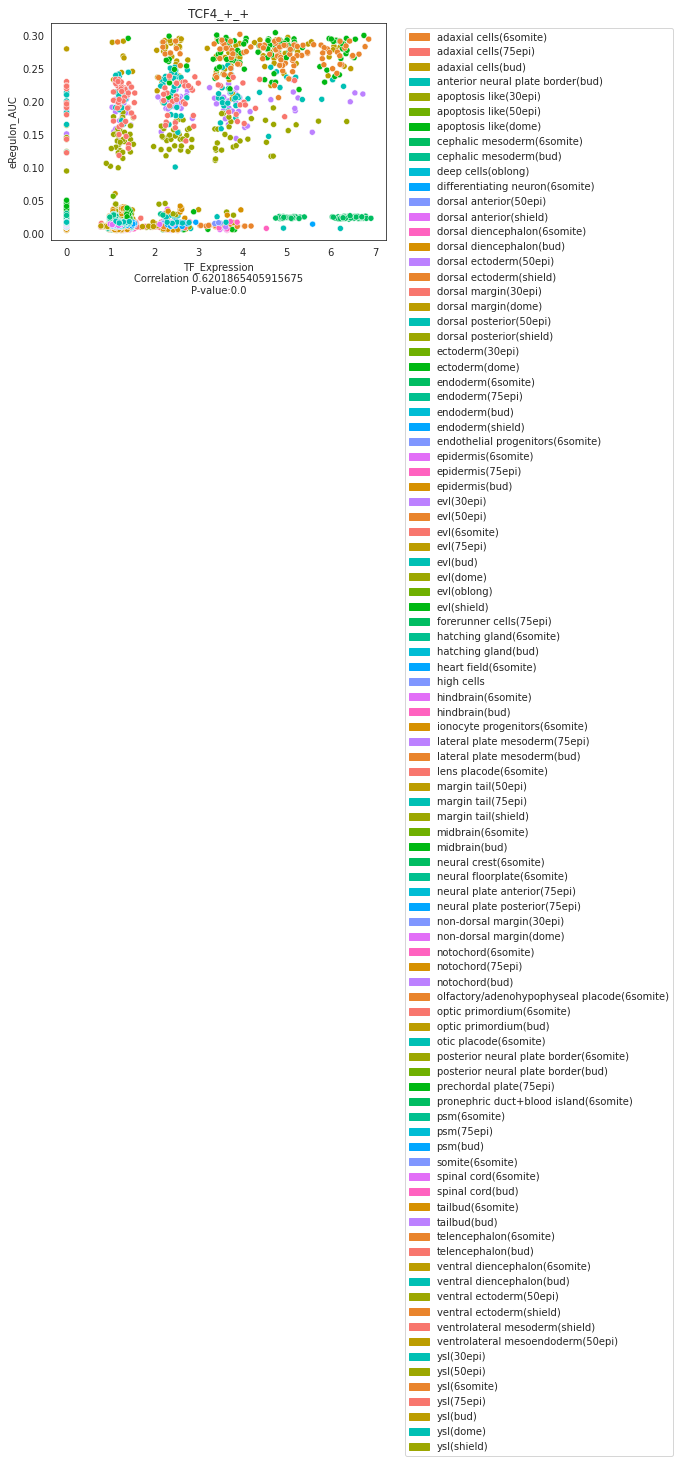

In [112]:
prune_plot(scplus_obj,
           'TCF4_+_+',
           pseudobulk_variable = 'GEX_cell.type',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           auc_key = 'eRegulon_AUC',
           signature_key = 'Region_based',
           seed=555)

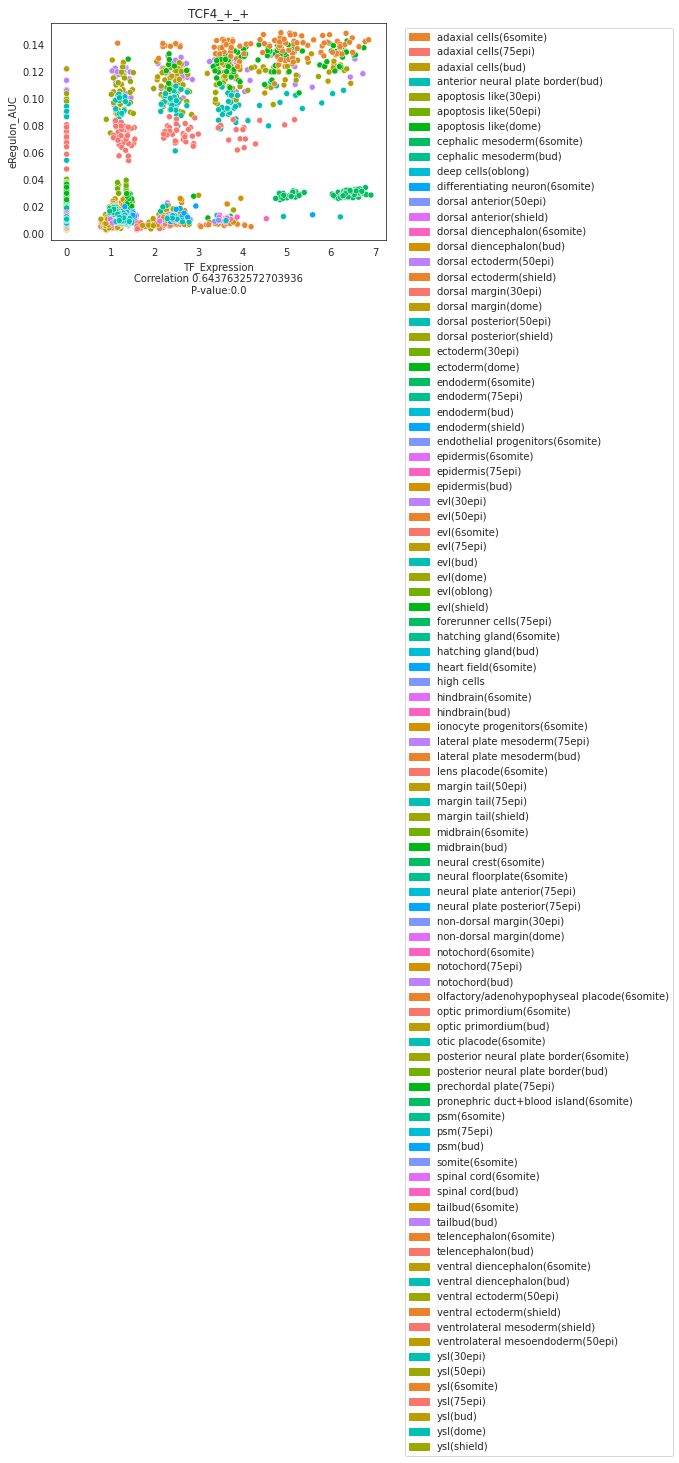

In [113]:
# Gene based
prune_plot(scplus_obj,
           'TCF4_+_+',
           pseudobulk_variable = 'GEX_cell.type',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           auc_key = 'eRegulon_AUC',
           signature_key = 'Gene_based',
           seed=555)

In [58]:
## output some files
infile = open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withBinarizedAUC.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()

In [59]:
scplus_obj.uns.keys()


dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons_importance', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'selected_eRegulons', 'eRegulon_AUC_thresholds'])

In [75]:
# TF_cistrome_correlation (eGRN_gene_based)
scplus_obj.uns['TF_cistrome_correlation']['GEX_cell.type_eGRN_gene_based'].to_csv("output/scenicplus/TF_cistrome_gene_based_correlation.txt",sep ='\t',index=False,header=True)


In [77]:
# TF_cistrome_correlation (eGRN__region_based)
scplus_obj.uns['TF_cistrome_correlation']['GEX_cell.type_eGRN__region_based'].to_csv("output/scenicplus/TF_cistrome_region_based_correlation.txt",sep ='\t',index=False,header=True)


##### D. Identification of high quality regulons
We will select a subset of regulons based on the correlation between the region based and the gene based regulons. We will only use the extended eRegulon if there is not a direct eRegulon available.

In [114]:
# Correlation between region based regulons and gene based regulons
df1 = scplus_obj.uns['eRegulon_AUC']['Gene_based'].copy()
df2 = scplus_obj.uns['eRegulon_AUC']['Region_based'].copy()
df1.columns = [x.split('_(')[0] for x in df1.columns]
df2.columns = [x.split('_(')[0] for x in df2.columns]
correlations = df1.corrwith(df2, axis = 0)
correlations = correlations[abs(correlations) > 0.6] 
# Kepp only R2G +
keep = [x for x in correlations.index if '+_+' in x] + [x for x in correlations.index if '-_+' in x]
# Keep extended if not direct
extended = [x for x in keep if 'extended' in x]
direct = [x for x in keep if not 'extended' in x]
keep_extended = [x for x in extended if not x.replace('extended_', '') in direct]
keep = direct + keep_extended
# Keep regulons with more than 10 genes
keep_gene = [x for x in scplus_obj.uns['eRegulon_AUC']['Gene_based'].columns if x.split('_(')[0] in keep]
keep_gene = [x for x in keep_gene if (int(x.split('_(')[1].replace('g)', '')) > 10)]
keep_all = [x.split('_(')[0] for x in keep_gene]
keep_region = [x for x in scplus_obj.uns['eRegulon_AUC']['Region_based'].columns if x.split('_(')[0] in keep]
scplus_obj.uns['selected_eRegulons'] = {}
scplus_obj.uns['selected_eRegulons']['Gene_based'] = keep_gene
scplus_obj.uns['selected_eRegulons']['Region_based'] = keep_region

##### E. Overlap between eRegulons
In addition, to assess which eRegulons tend to be enriched in the same group of cells we can generate a correlation plot as well

In [7]:
infile = open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withRSS.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()

In [ ]:
correlation_heatmap(scplus_obj,
                    auc_key = 'eRegulon_AUC',
                    signature_keys = ['Gene_based'],
                    selected_regulons = scplus_obj.uns['selected_eRegulons']['Gene_based'],
                    fcluster_threshold = 0.1,
                    save = 'output/network_analysis_results/regulon_cluster.pdf',
                    fontsize = 3)

In [ ]:
# We can also check the overlap between eRegulons:
jaccard_heatmap(scplus_obj,
                    gene_or_region_based = 'Gene_based',
                    signature_key = 'eRegulon_signatures',
                    selected_regulons = scplus_obj.uns['selected_eRegulons']['Gene_based'],
                    fcluster_threshold = 0.1,
                    fontsize = 3,
                    save = 'output/network_analysis_results/regulon_overlap.pdf',
                    method='intersect')

In [ ]:
# we can also binarize the eRegulons as in SCENIC. This information will be used afterwards for generating the loom file
# it takes 45 min
binarize_AUC(scplus_obj,
             auc_key='eRegulon_AUC',
             out_key='eRegulon_AUC_thresholds',
             signature_keys=['Gene_based', 'Region_based'],
             n_cpu=8)

In [117]:
with open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withBinarizedAUC.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

##### F. eRegulon specificity scores

Recently, a novel method was developed and used to quantify the specificity of the regulons (from SCENIC) across different cell types (Suo et al., 2018). The RSS (Regulon Specificity Score) does not require binarization of a regulon’s enrichment score distribution and measures the distance between this distribution and the distribution of group annotations using the Jensen–Shannon Divergence. For a given group, the RSS for all predicted regulons is ranked from high to low, and highly group-specific regulons are spotted as outliers. This method can be applied to eRegulons as well.

In [79]:
infile = open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withBinarizedAUC.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()

In [126]:
regulon_specificity_scores(scplus_obj,
                         'GEX_cell.type',
                         signature_keys=['Gene_based'],
                         selected_regulons=scplus_obj.uns['selected_eRegulons']['Gene_based'],
                         out_key_suffix='_gene_based',
                         scale=False)

/scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



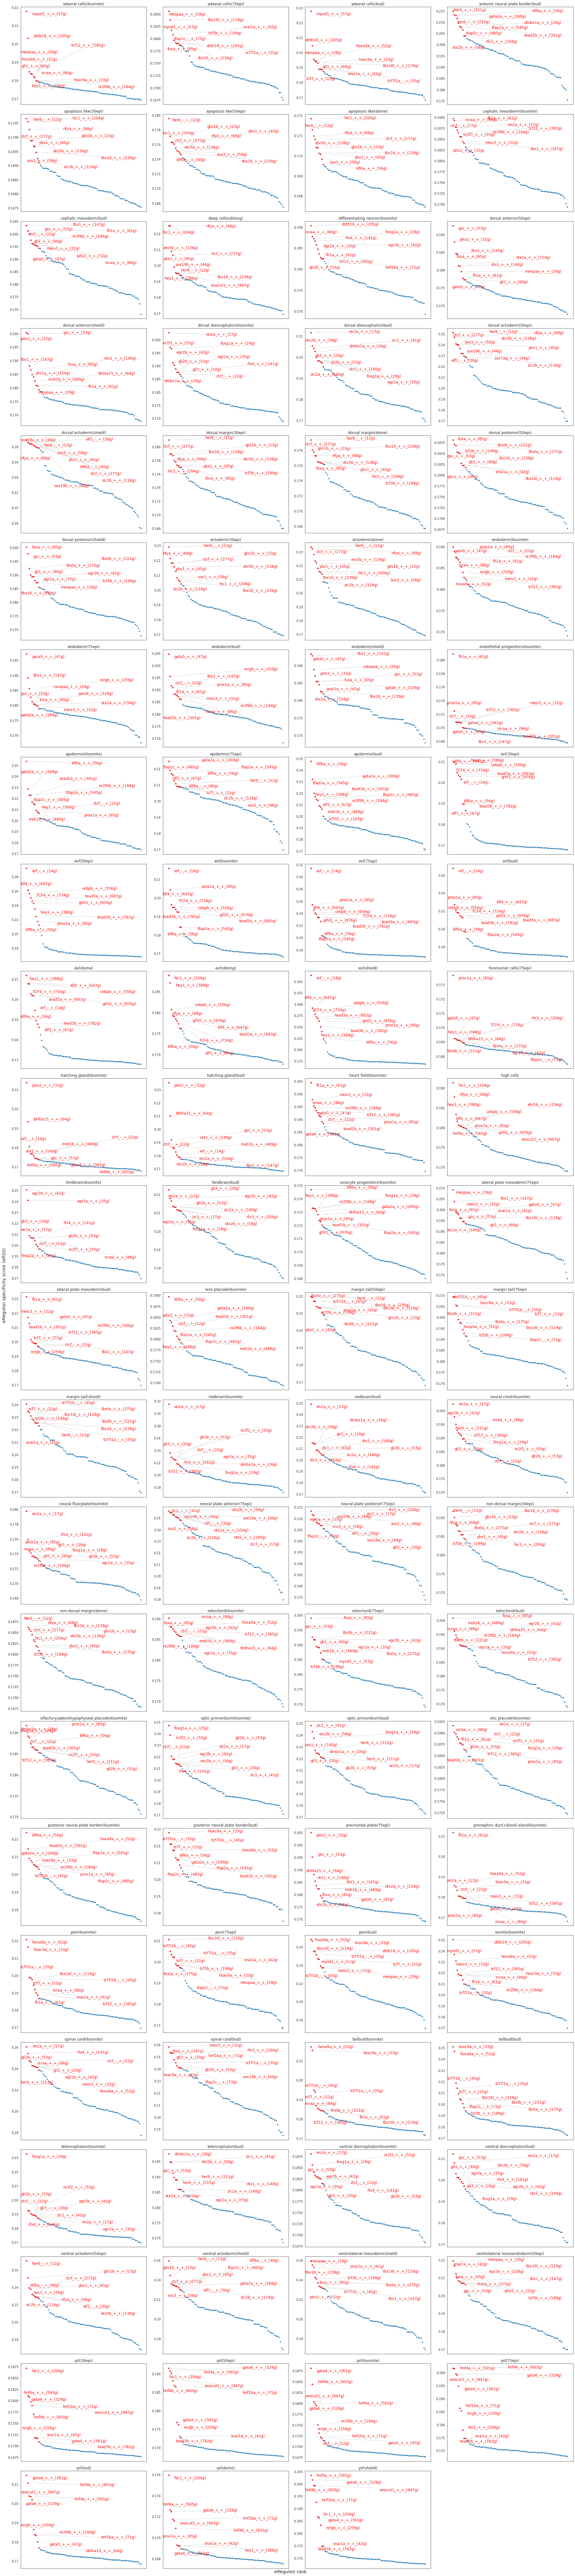

In [127]:
# it takes several min
plot_rss(scplus_obj, 'GEX_cell.type_gene_based', num_columns=4, top_n=10,
        save='output/network_analysis_results/celltype_specific_regulon.pdf')


In [18]:
#from scenicplus.plotting.dotplot import *
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['RSS']['GEX_cell.type_gene_based'],
        color_matrix = scplus_obj.to_df('EXP'),
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'GEX_cell.type',
        subset_eRegulons = scplus_obj.uns['selected_eRegulons']['Gene_based'],
        figsize = (25, 20),
        orientation = 'vertical',
        save = 'output/network_analysis_results/regulon_specificity.pdf',
        split_repressor_activator=True)

/scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 25 x 20 in image.

/scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: output/network_analysis_results/regulon_specificity.pdf



In [65]:
colnames = list()
for col in scplus_obj.uns['eRegulon_AUC']['Region_based'].columns:
    if 'extended' not in col and ('+_+' in col or '-_+' in col):
        colnames += [col]

In [67]:
len(colnames)

141

In [68]:
scplus_obj.uns['eRegulon_AUC']['Region_based_withoutExtend'] = scplus_obj.uns['eRegulon_AUC']['Region_based'][colnames]

In [69]:
scplus_obj.uns['eRegulon_AUC']['Region_based_withoutExtend']

TCF4_+_+_(2024r)  TCF4_-_+_(34r)  \
Cell                                                                        
30epi_AAACAGCCAGTTGCGT-1___cisTopic              0.236184        0.029294   
30epi_AAACCAACACCTAAGC-1___cisTopic              0.013967        0.064256   
30epi_AAACCGAAGGTTTGCG-1___cisTopic              0.014294        0.071337   
30epi_AAACGCGCAGTAAGTA-1___cisTopic              0.013777        0.056596   
30epi_AAAGCACCAGCATTAT-1___cisTopic              0.014109        0.058481   
...                                                   ...             ...   
shield_s4_TTTGTCTAGGTTTGAC-1___cisTopic          0.016303        0.082319   
shield_s4_TTTGTCTAGTCACCTC-1___cisTopic          0.014467        0.043104   
shield_s4_TTTGTCTAGTCAGGCC-1___cisTopic          0.016600        0.128103   
shield_s4_TTTGTGGCACATGCTA-1___cisTopic          0.013606        0.028060   
shield_s4_TTTGTTGGTATTGAGT-1___cisTopic          0.313955        0.030738   

                                         atf3_+_+_(33r)  bhlha15_+_+_(79r)  \
Cell                                                                         
30epi_AAACAGCCAGTTGCGT-1___cisTopic            0.232283           0.162929   
30epi_AAACCAACACCTAAGC-1___cisTopic            0.175003           0.072468   
30epi_AAACCGAAGGTTTGCG-1___cisTopic            0.175724           0.069385   
30epi_AAACGCGCAGTAAGTA-1___cisTopic            0.193737           0.081006   
30epi_AAAGCACCAGCATTAT-1___cisTopic            0.184313           0.071980   
...                                                 ...                ...   
shield_s4_TTTGTCTAGGTTTGAC-1___cisTopic        0.118115           0.077388   
shield_s4_TTTGTCTAGTCACCTC-1___cisTopic        0.131677           0.121333   
shield_s4_TTTGTCTAGTCAGGCC-1___cisTopic        0.099268           0.079432   
shield_s4_TTTGTGGCACATGCTA-1___cisTopic        0.143696           0.186219   
shield_s4_TTTGTTGGTATTGAGT-1___cisTopic        0.107686           0.213307   

                                         bhlhe41_+_+_(65r)  cebpb_+_+_(942r)  \
Cell                                                                           
30epi_AAACAGCCAGTTGCGT-1___cisTopic               0.122100          0.190718   
30epi_AAACCAACACCTAAGC-1___cisTopic               0.138885          0.004360   
30epi_AAACCGAAGGTTTGCG-1___cisTopic               0.142614          0.004268   
30epi_AAACGCGCAGTAAGTA-1___cisTopic               0.184027          0.004791   
30epi_AAAGCACCAGCATTAT-1___cisTopic               0.155580          0.003913   
...                                                    ...               ...   
shield_s4_TTTGTCTAGGTTTGAC-1___cisTopic           0.181197          0.004776   
shield_s4_TTTGTCTAGTCACCTC-1___cisTopic           0.191412          0.004147   
shield_s4_TTTGTCTAGTCAGGCC-1___cisTopic           0.146422          0.003817   
shield_s4_TTTGTGGCACATGCTA-1___cisTopic           0.194413          0.004218   
shield_s4_TTTGTTGGTATTGAGT-1___cisTopic           0.121744          0.249302   

                                         creb3l2_+_+_(10r)  ctcf_+_+_(502r)  \
Cell                                                                          
30epi_AAACAGCCAGTTGCGT-1___cisTopic               0.123698         0.026957   
30epi_AAACCAACACCTAAGC-1___cisTopic               0.250777         0.053468   
30epi_AAACCGAAGGTTTGCG-1___cisTopic               0.261329         0.053448   
30epi_AAACGCGCAGTAAGTA-1___cisTopic               0.375361         0.047252   
30epi_AAAGCACCAGCATTAT-1___cisTopic               0.376766         0.046059   
...                                                    ...              ...   
shield_s4_TTTGTCTAGGTTTGAC-1___cisTopic           0.348147         0.036602   
shield_s4_TTTGTCTAGTCACCTC-1___cisTopic           0.507955         0.034547   
shield_s4_TTTGTCTAGTCAGGCC-1___cisTopic           0.302809         0.032908   
shield_s4_TTTGTGGCACATGCTA-1___cisTopic           0.459560         0.035174   
shield_s4_TTTGTTGGTATTGAGT-1___cisT

In [71]:
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC']['Region_based_withoutExtend'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'GEX_cell.type',
        subset_eRegulons = scplus_obj.uns['selected_eRegulons']['Gene_based'],
        figsize = (25, 20),
        orientation = 'vertical',
        save = 'output/network_analysis_results/regulon_enhancerActivity.pdf',

        split_repressor_activator=True)




/scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 25 x 20 in image.

/scicore/home/schiera/liu0005/miniconda3/envs/scenicplus/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: output/network_analysis_results/regulon_enhancerActivity.pdf



In [30]:
scplus_obj.uns['RSS']['GEX_cell.type_gene_based']

TCF4_+_+_(734g)  bhlha15_+_+_(64g)  \
evl(30epi)                       0.204734           0.173197   
dorsal margin(30epi)             0.172401           0.170434   
non-dorsal margin(30epi)         0.175760           0.174109   
ectoderm(30epi)                  0.187082           0.176057   
apoptosis like(30epi)            0.168281           0.168059   
...                                   ...                ...   
dorsal ectoderm(shield)          0.224567           0.209960   
endoderm(shield)                 0.174806           0.178771   
evl(shield)                      0.278154           0.188867   
ysl(shield)                      0.170037           0.171708   
dorsal anterior(shield)          0.172001           0.182495   

                          cebpb_+_+_(556g)  ctcf_+_+_(277g)  ctcf_-_+_(22g)  \
evl(30epi)                        0.208967         0.170580        0.170599   
dorsal margin(30epi)              0.172491         0.178957        0.168433   
non-dorsal margin(30epi)          0.176001         0.186304        0.168291   
ectoderm(30epi)                   0.188877         0.218329        0.170317   
apoptosis like(30epi)             0.168378         0.169877        0.167528   
...                                    ...              ...             ...   
dorsal ectoderm(shield)           0.223933         0.282054        0.188495   
endoderm(shield)                  0.174685         0.178753        0.173080   
evl(shield)                       0.285436         0.171548        0.180985   
ysl(shield)                       0.171291         0.168991        0.169667   
dorsal anterior(shield)           0.171776         0.173761        0.173514   

                          dmbx1a_+_+_(26g)  egr2a_+_+_(35g)  egr2b_+_+_(42g)  \
evl(30epi)                        0.168651         0.169338         0.170173   
dorsal margin(30epi)              0.172360         0.170333         0.171769   
non-dorsal margin(30epi)          0.174474         0.169623         0.171931   
ectoderm(30epi)                   0.185453         0.169627         0.173886   
apoptosis like(30epi)             0.167728         0.167645         0.167763   
...                                    ...              ...              ...   
dorsal ectoderm(shield)           0.232317         0.229591         0.219829   
endoderm(shield)                  0.177627         0.174959         0.177863   
evl(shield)                       0.168858         0.172374         0.172595   
ysl(shield)                       0.167780         0.168067         0.167683   
dorsal anterior(shield)           0.178601         0.171212         0.175501   

                          elf1_+_+_(67g)  elf1_-_+_(30g)  ...  \
evl(30epi)                      0.186495        0.168435  ...   
dorsal margin(30epi)            0.173713        0.175362  ...   
non-dorsal margin(30epi)        0.177755        0.178147  ...   
ectoderm(30epi)                 0.188271        0.201121  ...   
apoptosis like(30epi)           0.168408        0.168871  ...   
...                                  ...             ...  ...   
dorsal ectoderm(shield)         0.230558        0.285438  ...   
endoderm(shield)                0.178295        0.176696  ...   
evl(shield)                     0.219142        0.169095  ...   
ysl(shield)                     0.169875        0.168787  ...   
dorsal anterior(shield)         0.173359        0.171793  ...   

                          tead3b_+_+_(782g)  tfap2a_+_+_(545g)  \
evl(30epi)                         0.189761           0.180227   
dorsal margin(30epi)               0.172646           0.171010   
non-dorsal margin(30epi)           0.175526           0.173970   
ectoderm(30epi)                    0.188973           0.184852   
apoptosis like(30epi)              0.168435           0.168303   
...                                     ...                ...   
dorsal ectoderm(shield)            0.230473           0.233360   
endoderm(shield)                   0.1

In [131]:
#with open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withRSS.pkl', 'wb') as f:
 # dill.dump(scplus_obj, f)

##### G. Export to loom

In [7]:
infile = open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withRSS.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()

In [156]:
export_to_loom(scplus_obj,
               signature_key = 'Gene_based',
               tree_structure = ('10x_multiome_zebrafish', 'SCENIC+'),
               title = 'Tutorial - Gene based eGRN',
               nomenclature = "danRer11",
               out_fname=outDir + 'scenicplus/zebrafish_eGRN_gene_based.loom')

2022-11-09 22:19:28,505 SCENIC+      INFO     Formatting data
2022-11-09 22:19:31,483 SCENIC+      INFO     Creating minimal loom
2022-11-09 22:20:40,918 SCENIC+      INFO     Adding annotations
2022-11-09 22:20:44,780 SCENIC+      INFO     Exporting


In [ ]:
# memory is not enoug even for 270g  
export_to_loom(scplus_obj,
               signature_key = 'Region_based',
               tree_structure = ('10x_multiome_zebrafish', 'SCENIC+'),
               title = 'Tutorial - Gene based eGRN',
               nomenclature = "danRer11",
               out_fname=outDir + 'scenicplus/zebrafish_eGRN_region_based.loom')

2022-11-09 22:36:43,375 SCENIC+      INFO     Formatting data


##### H. Plotting networks

In [82]:
(scplus_obj.uns['selected_eRegulons']['Gene_based'])

['TCF4_+_+_(734g)',
 'bhlha15_+_+_(64g)',
 'cebpb_+_+_(556g)',
 'ctcf_+_+_(277g)',
 'ctcf_-_+_(22g)',
 'dmbx1a_+_+_(26g)',
 'egr2a_+_+_(35g)',
 'egr2b_+_+_(42g)',
 'elf1_+_+_(67g)',
 'elf1_-_+_(30g)',
 'en2a_+_+_(17g)',
 'erf_-_+_(14g)',
 'etv5b_+_+_(136g)',
 'fli1a_+_+_(61g)',
 'foxa_+_+_(85g)',
 'foxg1a_+_+_(29g)',
 'gata2a_+_+_(269g)',
 'gata4_+_+_(361g)',
 'gata5_+_+_(47g)',
 'gata6_+_+_(329g)',
 'gli1_+_+_(60g)',
 'gli2b_+_+_(53g)',
 'gli3_+_+_(20g)',
 'glis1b_+_+_(23g)',
 'grhl1_+_+_(976g)',
 'gsc_+_+_(53g)',
 'her6_+_+_(215g)',
 'her6_-_+_(12g)',
 'her9_+_+_(211g)',
 'hey1_+_+_(388g)',
 'hic1_+_+_(204g)',
 'hnf1ba_+_+_(71g)',
 'hnf4a_+_+_(565g)',
 'hnf4b_+_+_(603g)',
 'hoxa9a_+_+_(52g)',
 'hoxc9a_+_+_(33g)',
 'klf4_+_+_(647g)',
 'klf6a_+_+_(56g)',
 'klf6a_-_+_(40g)',
 'meis3_+_+_(32g)',
 'mespaa_+_+_(29g)',
 'myod1_+_+_(57g)',
 'nfya_+_+_(68g)',
 'nr2f2_+_+_(55g)',
 'nr2f6b_+_+_(184g)',
 'onecut1_+_+_(947g)',
 'otx1_+_+_(140g)',
 'otx2a_+_+_(154g)',
 'otx2b_+_+_(58g)',
 'pitx2_+

In [ ]:
(scplus_obj.uns['selected_eRegulons']['Gene_based']).to_csv(outDir + 'scenicplus/eRegulon_name.csv',sep='\t',index=False)  


In [85]:
with open(outDir + 'scenicplus/eRegulon_name.csv', 'w') as fp:
    for item in (scplus_obj.uns['selected_eRegulons']['Gene_based']):
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [27]:
scplus_obj.uns['RSS']['GEX_cell.type_gene_based'].to_csv(outDir + 'scenicplus/eRegulon_RSS.csv',sep='\t')

In [23]:
type(scplus_obj.uns['RSS']['GEX_cell.type_gene_based'])

pandas.core.frame.DataFrame

##### I. use non-filtered  regulons


In [7]:

infile = open(outDir + 'scenicplus/zf_highToSomite_scplusObject_withBinarizedAUC.pkl', 'rb')
scplus_obj = dill.load(infile) # (can't use pickle, only dill)
infile.close()


In [8]:
df1 = scplus_obj.uns['eRegulon_AUC']['Gene_based'].copy()
df2 = scplus_obj.uns['eRegulon_AUC']['Region_based'].copy()
df1.columns = [x.split('_(')[0] for x in df1.columns]
df2.columns = [x.split('_(')[0] for x in df2.columns]
correlations = df1.corrwith(df2, axis = 0)


In [32]:
scplus_obj.uns['eRegulon_AUC']['Gene_based'][['glis1b_+_+_(23g)']]

glis1b_+_+_(23g)
Cell                                                     
30epi_AAACAGCCAGTTGCGT-1___cisTopic              0.001865
30epi_AAACCAACACCTAAGC-1___cisTopic              0.255130
30epi_AAACCGAAGGTTTGCG-1___cisTopic              0.143493
30epi_AAACGCGCAGTAAGTA-1___cisTopic              0.275793
30epi_AAAGCACCAGCATTAT-1___cisTopic              0.093414
...                                                   ...
shield_s4_TTTGTCTAGGTTTGAC-1___cisTopic          0.162577
shield_s4_TTTGTCTAGTCACCTC-1___cisTopic          0.107476
shield_s4_TTTGTCTAGTCAGGCC-1___cisTopic          0.169321
shield_s4_TTTGTGGCACATGCTA-1___cisTopic          0.106902
shield_s4_TTTGTTGGTATTGAGT-1___cisTopic          0.024968

[40992 rows x 1 columns]

In [27]:
scplus_obj.uns['eRegulon_AUC']['Gene_based'].to_csv(outDir + 'scenicplus/eRegulon_AUC_Gene_based.csv',sep='\t')




In [11]:
correlations.to_csv(outDir + 'scenicplus/eRegulon_region_gene_correlation.csv',sep='\t')

In [22]:
all_regulons = [x for x in scplus_obj.uns['eRegulon_AUC']['Gene_based'].columns ]


In [24]:
regulon_specificity_scores(scplus_obj,
                         'GEX_cell.type',
                         signature_keys=['Gene_based'],
                         selected_regulons=all_regulons,
                         out_key_suffix='_gene_based',
                         scale=False)



In [25]:
scplus_obj.uns['RSS']['GEX_cell.type_gene_based'].to_csv(outDir + 'scenicplus/eRegulon_all_RSS.csv',sep='\t')

In [36]:
extended = [x for x in keep if 'extended' in x]
direct = [x for x in keep if not 'extended' in x]


In [39]:
keep_extended = [x for x in extended if not x.replace('extended_', '') in direct]


In [40]:
keep_extended

[]

## get imputed accessibility for peaks in avtivator regulons


In [7]:
## get imputed accessibility 
infile = open(outDir + 'DARs/normalized_imputed_acc_obj.pkl', 'rb')
imputed_acc_obj = pickle.load(infile)
infile.close()



In [8]:
imputed_acc_obj.mtx.shape

(444253, 40992)

In [9]:
df = pd.DataFrame(imputed_acc_obj.mtx, columns = imputed_acc_obj.cell_names,index = imputed_acc_obj.feature_names)


In [10]:
#df.to_csv(outDir+"normalized_imputed_acc.csv",sep="\t")

In [30]:
## based on cell name and peak name to get the normalized_imputed_acc
df.index

Index(['chr1:3434-3934', 'chr1:4536-5036', 'chr1:5204-5704', 'chr1:6039-6539',
       'chr1:6586-7086', 'chr1:7201-7701', 'chr1:7767-8267', 'chr1:9300-9800',
       'chr1:9812-10312', 'chr1:10474-10974',
       ...
       'chr25:37490311-37490811', 'chr25:37491119-37491619',
       'chr25:37492142-37492642', 'chr25:37492724-37493224',
       'chr25:37496381-37496881', 'chr25:37497140-37497640',
       'chr25:37497923-37498423', 'chr25:37498471-37498971',
       'chr25:37499517-37500017', 'chr25:37501299-37501799'],
      dtype='object', length=444253)

In [10]:
eRegulon_enhancer = pd.read_csv('output/network_analysis_results/results_28.12.2022/eRegulon.enhancers.txt',sep='\t')


In [12]:
df_eRegulon_enhancer = df.loc[eRegulon_enhancer['enhancer']]

In [13]:
df_eRegulon_enhancer.to_csv("output/network_analysis_results/results_28.12.2022/eRegulon.enhancers.normalized_imputed_acc.csv",sep="\t")

In [48]:
type(df_eRegulon_enhancer.columns)

pandas.core.indexes.base.Index

In [ ]:
for cellname in df_eRegulon_enhancer.columns:
    print(cellname.split('___'))